# Demo of the GTM on 10-Dimensional R-Vine-Copula Data

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 10 dimensional R-Vine-Copula as done in our [Paper](https://arxiv.org/pdf/2503.17845) Section 4.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv
# Helpers to generate specfific vines and analyze there conditional independencies
from pyvinecopulib_simulation_helpers import *

# Other Stuff
import numpy as np
import torch
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
from sklearn.metrics import roc_auc_score, roc_curve

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seeds(1)

### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a R-Vine-Copula and add Gaussian marginals. To create the Vine we use the functions `sample_random_pair_copulas`and `compute_conditional_dependence_table` from our helpers. Theses allow use to set independence copulas upon Tree 3 to add full conditional independencies as detailed in our Paper. The `df`contains a tables with the copulas, there parameters and there tree positions in a manner comparable to the conditional independence table later generated with the GTM.

In [3]:
D = 7  # dimension
rvine_structure = pv.RVineStructure.simulate(D)
pair_copulas = sample_random_pair_copulas(D,Independence_tree=3)
vine_model = pv.Vinecop.from_structure(structure=rvine_structure, pair_copulas=pair_copulas)
df = compute_conditional_dependence_table(vine_model)
#df

creating a table to compare the true dependence structure later on to what the gtm learned

In [4]:

df_true_structure = df[["tree","edge","conditioned variables", "conditioned variable 1", "conditioned variable 2", "dependence", "var_row", "var_col"]]
df_true_structure_sub = df_true_structure[["var_row", "var_col", "dependence"]]
df_true_structure_sub.loc[:, "var_row"] = df_true_structure_sub["var_row"] - 1
df_true_structure_sub.loc[:, "var_col"] = df_true_structure_sub["var_col"] - 1

The `pyvinecopulib`package offers to plot the tree structures:

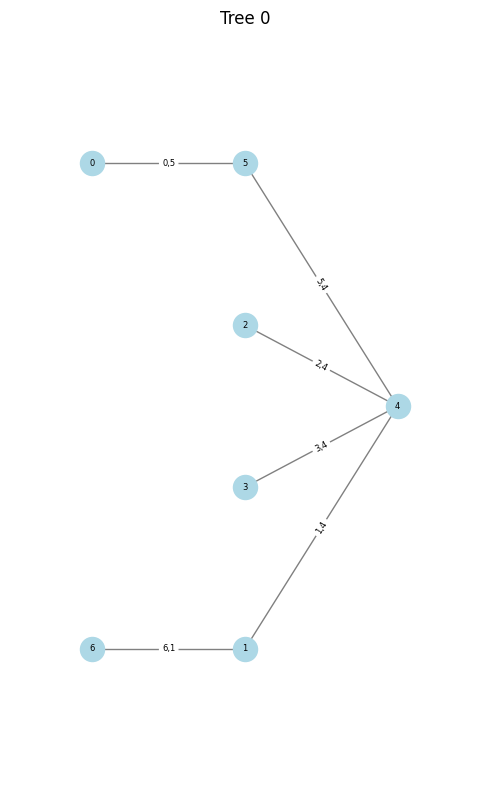

In [5]:
vine_model.plot(tree=[0])

In [6]:
# Train
N_train = 2000
simulated_data_uniform_train = vine_model.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = vine_model.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = vine_model.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [7]:
loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_train).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_validate).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(vine_model.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(simulated_data_test).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [8]:
copula_pv_est = vine_model
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [9]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [10]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [11]:
model_freq = GTM(
        number_variables = D,
        number_transformation_layers = 1,
        number_decorrelation_layers= 3,
        degree_transformations = 15,
        degree_decorrelation = 30,
        spline_transformation = "bspline",
        spline_decorrelation = "bspline",
        transformation_spline_range = (-10, 10),
        device = "cuda" if torch.cuda.is_available() else "cpu")

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [12]:
#model_freq.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

In [13]:
#model_freq.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

#### 3.1 GTM

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [14]:
study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-10 16:45:17,776] A new study created in RDB with name: no-name-a80df472-9885-4d53-9296-70d0eda0b08b


  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:620: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:43,  3.11it/s]

current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4272902011871338
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.424118995666504
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4146559238433838
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:02, 16.27it/s]

current_loss: tensor(2.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4121438264846802
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4111101627349854
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4106272459030151
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410435438156128
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0

  1%|          | 15/2000 [00:00<01:21, 24.47it/s]

tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4104732275009155
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4176, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102873802185059
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4103188514709473
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4105273485183716
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410329818725586
current_loss: tensor(1.4149, device='cuda:0'

  1%|          | 21/2000 [00:01<01:13, 26.81it/s]

current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4101721048355103
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4101659059524536
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.410226821899414
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102210998535156
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102466106414795
current_loss: tensor(1.4148, d

  1%|          | 21/2000 [00:01<01:41, 19.43it/s]


current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4102323055267334
Early Stop at iteration 21 with minimal loss tensor(1.4102, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4165, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<05:52,  5.67it/s]

current_loss: tensor(1.4044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3113852739334106
current_loss: tensor(1.3161, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1946104764938354
current_loss: tensor(1.2096, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1996, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1587, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<02:56, 11.28it/s]

current_loss_val:  1.1411725282669067
current_loss: tensor(1.1587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1337214708328247
current_loss: tensor(1.1493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.121463656425476
current_loss: tensor(1.1342, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:51, 11.64it/s]

current_loss_val:  1.09865403175354
current_loss: tensor(1.1123, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0847878456115723
current_loss: tensor(1.1025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0736749172210693
current_loss: tensor(1.0942, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:38, 12.54it/s]

current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0650478601455688
current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558582544326782
current_loss: tensor(1.0819, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:41, 12.35it/s]

current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0487565994262695


  1%|          | 13/2000 [00:01<02:32, 13.01it/s]

current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0433663129806519
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0394301414489746
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0359060764312744


  1%|          | 15/2000 [00:01<02:28, 13.34it/s]

current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0172793865203857
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.011712670326233
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0094504356384277


  1%|          | 19/2000 [00:01<02:22, 13.90it/s]

current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0076543092727661
current_loss: tensor(1.0320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0018508434295654
current_loss: tensor(1.0227, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0052754878997803


  1%|          | 21/2000 [00:01<02:21, 14.01it/s]

current_loss: tensor(1.0223, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9984261989593506
current_loss: tensor(1.0162, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9969580173492432
current_loss: tensor(1.0145, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:01<02:19, 14.15it/s]

current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.995307981967926


  1%|▏         | 25/2000 [00:01<02:18, 14.25it/s]

current_loss: tensor(1.0126, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9942426085472107
current_loss: tensor(1.0114, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9936195611953735
current_loss: tensor(1.0105, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.992974042892456


  1%|▏         | 27/2000 [00:02<02:18, 14.24it/s]

current_loss: tensor(1.0093, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9926971793174744
current_loss: tensor(1.0088, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9922269582748413
current_loss: tensor(1.0074, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:18, 14.21it/s]

current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9921810626983643


  2%|▏         | 31/2000 [00:02<02:17, 14.31it/s]

current_loss: tensor(1.0065, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9922175407409668
current_loss: tensor(1.0052, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9938094019889832
current_loss: tensor(1.0044, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9924622774124146


  2%|▏         | 33/2000 [00:02<02:18, 14.24it/s]

current_loss: tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9919387698173523
current_loss: tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9902780055999756
current_loss: tensor(1.0020, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:02<02:17, 14.25it/s]

current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898936748504639


  2%|▏         | 37/2000 [00:02<02:16, 14.33it/s]

current_loss: tensor(1.0013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9897903203964233
current_loss: tensor(1.0012, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895179271697998
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9893128275871277


  2%|▏         | 39/2000 [00:02<02:26, 13.37it/s]

current_loss: tensor(1.0006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9887298941612244
current_loss: tensor(0.9997, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9882799386978149
current_loss: tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:20, 13.90it/s]

current_loss_val:  0.9867449402809143
current_loss: tensor(0.9965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9852344393730164
current_loss: tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9834370613098145
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:03<02:20, 13.95it/s]

current_loss_val:  0.9809714555740356
current_loss: tensor(0.9921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9803603291511536
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774304032325745
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:03<02:19, 13.98it/s]

current_loss_val:  0.9749553203582764
current_loss: tensor(0.9877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747010469436646
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748644828796387


  2%|▏         | 49/2000 [00:03<02:20, 13.92it/s]

current_loss: tensor(0.9860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:03<02:25, 13.37it/s]

current_loss_val:  0.9749528765678406
current_loss: tensor(0.9853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755483269691467
current_loss: tensor(0.9846, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754765033721924
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:27, 13.16it/s]


current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975356936454773
Early Stop at iteration 52 with minimal loss tensor(0.9747, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:29,725] Trial 0 finished with value: -6.822907447814941 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.445776079392084, 'penalty_decorrelation_ridge_second_difference': 10.603566415523073}. Best is trial 0 with value: -6.822907447814941.
  0%|          | 2/2000 [00:00<02:21, 14.15it/s]

current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754766821861267
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746224880218506
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743819832801819


  0%|          | 6/2000 [00:00<02:19, 14.32it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741085171699524
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743427634239197
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736821055412292


  0%|          | 8/2000 [00:00<02:18, 14.38it/s]

current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730277061462402
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727983474731445
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718912839889526


  0%|          | 10/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(0.9649, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692191481590271
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968734085559845
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:24, 13.71it/s]

current_loss_val:  0.9683967232704163
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668896198272705
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656072854995728
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.90it/s]

current_loss_val:  0.9648094177246094
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643518924713135
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961152195930481
current_loss: tensor(0.9578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:32, 13.02it/s]

current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9604128003120422
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9596598148345947
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593687653541565


  1%|          | 22/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589258432388306
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958554744720459
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9580739140510559


  1%|▏         | 26/2000 [00:01<02:21, 13.93it/s]

current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957538366317749
current_loss: tensor(0.9537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573850631713867
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572864174842834


  1%|▏         | 28/2000 [00:02<02:20, 14.04it/s]

current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568752646446228
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559825658798218
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:26, 13.43it/s]

current_loss_val:  0.95560222864151
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9550682902336121
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546085000038147
current_loss: tensor(0.9507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:23, 13.70it/s]

current_loss_val:  0.9539264440536499
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95334792137146
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952982485294342
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:21, 13.88it/s]

current_loss_val:  0.9528526663780212
current_loss: tensor(0.9492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527145028114319
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526020884513855


  2%|▏         | 40/2000 [00:03<03:00, 10.88it/s]

current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525684714317322
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952704668045044
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528493285179138


  2%|▏         | 42/2000 [00:03<02:33, 12.72it/s]

current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95276939868927
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526818990707397
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526691436767578
Early Stop at iteration 42 with minimal loss tensor(0.9526, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:34,475] Trial 1 finished with value: -6.667979717254639 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.8233814172761873, 'penalty_decorrelation_ridge_second_difference': 3.316608622210164}. Best is trial 1 with value: -6.667979717254639.
  0%|          | 2/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756852388381958
current_loss: tensor(0.9869, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748916029930115
current_loss: tensor(0.9861, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747125506401062


  0%|          | 6/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9858, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746053218841553
current_loss: tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756602644920349
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749562740325928


  0%|          | 8/2000 [00:00<02:20, 14.17it/s]

current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97458416223526
current_loss: tensor(0.9835, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9744256138801575
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739686250686646


  0%|          | 10/2000 [00:00<02:28, 13.36it/s]

current_loss: tensor(0.9825, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732265472412109
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728490114212036
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:22, 13.92it/s]

current_loss_val:  0.9725714325904846
current_loss: tensor(0.9808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725649952888489
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725844860076904
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:21, 13.98it/s]

current_loss_val:  0.9726760387420654
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727086424827576
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725325107574463
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:19, 14.21it/s]

current_loss_val:  0.9723548889160156
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723180532455444
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721810817718506
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:18, 14.23it/s]

current_loss_val:  0.971807599067688
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717368483543396
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717222452163696
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:17, 14.37it/s]

current_loss_val:  0.9716789722442627
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715924263000488
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715909361839294
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:24, 13.66it/s]

current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718698263168335
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715433716773987
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710530042648315
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.34it/s]

current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697787761688232
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684528112411499
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675207734107971


  2%|▏         | 34/2000 [00:02<02:24, 13.64it/s]

current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659264087677002
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9650687575340271
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9644473791122437


  2%|▏         | 38/2000 [00:02<02:20, 14.00it/s]

current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9634768962860107
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618120789527893
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605069756507874


  2%|▏         | 40/2000 [00:02<02:19, 14.10it/s]

current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959598958492279
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.958976149559021
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584037065505981


  2%|▏         | 42/2000 [00:03<02:26, 13.37it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957867443561554
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9566115736961365
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:28, 13.20it/s]

current_loss_val:  0.9545498490333557
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540693163871765
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539344310760498
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:24, 13.50it/s]

current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9530983567237854
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528692960739136
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528603553771973
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:24, 13.46it/s]

current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9527372717857361
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526277184486389
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526042938232422


  3%|▎         | 54/2000 [00:03<02:36, 12.47it/s]

current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.952635645866394
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520497918128967
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:30, 12.96it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520106911659241
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522367119789124
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522222280502319


  3%|▎         | 58/2000 [00:04<02:32, 12.73it/s]

current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522140026092529
current_loss: tensor(0.9574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522743821144104
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:04<02:26, 13.29it/s]


current_loss_val:  0.9522808194160461
Early Stop at iteration 59 with minimal loss tensor(0.9520, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:40,420] Trial 2 finished with value: -6.6640753746032715 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.301306479359125, 'penalty_decorrelation_ridge_second_difference': 11.346326095838032}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:21, 14.14it/s]

current_loss: tensor(1.0250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750771522521973
current_loss: tensor(1.0229, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9774501919746399
current_loss: tensor(1.0186, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790019392967224


  0%|          | 5/2000 [00:00<02:47, 11.94it/s]

current_loss: tensor(1.0147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9808536171913147
current_loss: tensor(1.0141, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9790425300598145
current_loss: tensor(1.0128, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0122, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9784023761749268
Early Stop at iteration 5 with minimal loss tensor(0.9751, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:42,936] Trial 3 finished with value: -6.825540065765381 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.219976117728137, 'penalty_decorrelation_ridge_second_difference': 27.146293495306647}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:49, 11.77it/s]

current_loss: tensor(0.9848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753022789955139
current_loss: tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752236008644104
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:31, 13.15it/s]

current_loss_val:  0.9755236506462097
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767042398452759
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762691259384155
current_loss: tensor(0.9804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:52, 11.53it/s]

current_loss_val:  0.9758093953132629
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754667282104492
Early Stop at iteration 6 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:45,235] Trial 4 finished with value: -6.826565265655518 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.556359471975585, 'penalty_decorrelation_ridge_second_difference': 24.667303743026995}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:20, 14.23it/s]

current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755988717079163
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747400283813477
current_loss: tensor(0.9822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745528101921082


  0%|          | 6/2000 [00:00<02:19, 14.28it/s]

current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974368691444397
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974700927734375
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743024706840515


  0%|          | 8/2000 [00:00<02:19, 14.31it/s]

current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739943146705627
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742518067359924
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735845327377319


  0%|          | 10/2000 [00:00<02:31, 13.16it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972395658493042
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716238975524902
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.50it/s]

current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712938070297241
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711728692054749
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712600111961365
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:28, 13.37it/s]

current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711235761642456
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9706984162330627
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:43, 12.13it/s]

current_loss_val:  0.9703193306922913
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701002836227417
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692763090133667
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:31, 13.08it/s]

current_loss_val:  0.9684503078460693
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684047102928162
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.968133807182312
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:27, 13.43it/s]

current_loss_val:  0.9680954813957214
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682925343513489
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684628248214722
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:31, 13.00it/s]

current_loss_val:  0.9684236645698547
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684348106384277
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685648679733276
Early Stop at iteration 27 with minimal loss tensor(0.9681, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:48,920] Trial 5 finished with value: -6.776669025421143 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.42595027889244, 'penalty_decorrelation_ridge_second_difference': 5.101523160943989}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:17, 14.51it/s]

current_loss: tensor(0.9929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755128026008606
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750750660896301
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750903844833374


  0%|          | 4/2000 [00:00<02:17, 14.56it/s]

current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754450917243958
current_loss: tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757636785507202
current_loss: tensor(0.9893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:49, 11.75it/s]

current_loss_val:  0.9756237268447876
current_loss: tensor(0.9889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750810265541077
Early Stop at iteration 6 with minimal loss tensor(0.9751, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:45:51,744] Trial 6 finished with value: -6.825525283813477 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.729781558473347, 'penalty_decorrelation_ridge_second_difference': 14.1397154502284}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:20, 14.22it/s]

current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757195711135864
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749671816825867
current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748094081878662


  0%|          | 6/2000 [00:00<02:19, 14.33it/s]

current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747745990753174
current_loss: tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763670563697815
current_loss: tensor(0.9964, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756228923797607


  0%|          | 8/2000 [00:00<02:18, 14.36it/s]

current_loss: tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752512574195862
current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752073287963867
current_loss: tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747441411018372


  0%|          | 10/2000 [00:00<02:28, 13.42it/s]

current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746082425117493
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743062257766724
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:22, 13.95it/s]

current_loss_val:  0.9740728139877319
current_loss: tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740467071533203
current_loss: tensor(0.9913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974108099937439
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.96it/s]

current_loss_val:  0.9745503664016724
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747491478919983
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745012521743774
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:31, 13.11it/s]


current_loss_val:  0.97423255443573
Early Stop at iteration 17 with minimal loss tensor(0.9740, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:45:54,851] Trial 7 finished with value: -6.818326950073242 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.17496139116514, 'penalty_decorrelation_ridge_second_difference': 2.7628839289784697}. Best is trial 2 with value: -6.6640753746032715.
  0%|          | 2/2000 [00:00<02:21, 14.17it/s]

current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754349589347839
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750069379806519
current_loss: tensor(0.9794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750030636787415


  0%|          | 4/2000 [00:00<02:18, 14.38it/s]

current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752838611602783
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753051400184631
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.89it/s]

current_loss_val:  0.975008487701416
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9732978940010071
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731577634811401
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.33it/s]

current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9728988409042358
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725755453109741
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721449613571167
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.67it/s]

current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724007844924927
current_loss: tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718025326728821
current_loss: tensor(0.9722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715175628662109
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:22, 13.93it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712442755699158
current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9703805446624756
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694505929946899
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:19, 14.15it/s]

current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694136381149292
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693958759307861
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692720174789429
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:20, 14.12it/s]

current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9691025018692017
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680532813072205
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677894711494446


  1%|          | 24/2000 [00:01<02:29, 13.19it/s]

current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676773548126221
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670997262001038
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:33, 12.86it/s]

current_loss_val:  0.9670904874801636
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9666223526000977
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:40, 12.27it/s]

current_loss_val:  0.9660987854003906
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659870862960815
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659225344657898
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:33, 12.81it/s]

current_loss_val:  0.9657803773880005
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659652709960938
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657831788063049
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.59it/s]

current_loss_val:  0.9657527208328247
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657474756240845
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9659734964370728
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:22, 13.76it/s]

current_loss_val:  0.9657834768295288
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656293392181396
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.965446412563324
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:25, 13.46it/s]

current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653850197792053
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652713537216187
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648187756538391
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:30, 13.02it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638980031013489
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9619213342666626
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597060680389404


  2%|▏         | 46/2000 [00:03<02:26, 13.30it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575245976448059
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955634593963623
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:36, 12.47it/s]

current_loss_val:  0.9545472860336304
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532406330108643
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523077607154846
current_loss: tensor(0.9561, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:40, 12.15it/s]

current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522415399551392
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520038962364197
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951440691947937


  3%|▎         | 56/2000 [00:04<02:26, 13.26it/s]

current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515599608421326
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513979554176331
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513695240020752


  3%|▎         | 58/2000 [00:04<02:22, 13.66it/s]

current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515069723129272
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514946937561035
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:31, 12.79it/s]

current_loss_val:  0.951222836971283
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513207077980042
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951259970664978
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:04<02:29, 12.94it/s]

current_loss_val:  0.951383650302887
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951532244682312
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516123533248901
Early Stop at iteration 63 with minimal loss tensor(0.9512, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:01,460] Trial 8 finished with value: -6.658560752868652 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.8115511597689493, 'penalty_decorrelation_ridge_second_difference': 20.703998218669845}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:22, 14.01it/s]

current_loss: tensor(0.9716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754675030708313
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746196269989014
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743735194206238


  0%|          | 6/2000 [00:00<02:20, 14.16it/s]

current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9740960001945496
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743810296058655
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736766815185547


  0%|          | 8/2000 [00:00<02:20, 14.19it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730011224746704
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727173447608948
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717714786529541


  0%|          | 10/2000 [00:00<02:19, 14.22it/s]

current_loss: tensor(0.9656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692901968955994
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688135385513306
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683862924575806
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677395224571228
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9672162532806396
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.42it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966681718826294
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664145112037659
current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658756256103516
current_loss: tensor(0.9609, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:23, 13.76it/s]

current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658612012863159
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9657177925109863
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655835032463074
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:22, 13.89it/s]

current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654616713523865
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9646360278129578
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642476439476013


  1%|          | 24/2000 [00:01<02:39, 12.39it/s]

current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637858271598816
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620538353919983
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:42, 12.11it/s]

current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9617567658424377
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609887003898621
current_loss: tensor(0.9570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:45, 11.93it/s]

current_loss_val:  0.9603850841522217
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9598928689956665
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605250358581543
current_loss: tensor(0.9556, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:40, 12.26it/s]

current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.959522545337677
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593322277069092
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590756297111511
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:34, 12.67it/s]

current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590360522270203
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9589062333106995
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586359858512878


  2%|▏         | 38/2000 [00:02<02:29, 13.09it/s]

current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95853191614151
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582253098487854
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578114151954651


  2%|▏         | 42/2000 [00:03<02:24, 13.59it/s]

current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578045606613159
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578033089637756
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577553868293762


  2%|▏         | 44/2000 [00:03<02:28, 13.15it/s]

current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577875137329102
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577505588531494
current_loss: tensor(0.9531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:33, 12.75it/s]

current_loss_val:  0.9577142000198364
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576826691627502
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9576858282089233
current_loss: tensor(0.9529, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:25, 13.43it/s]

current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957716166973114
current_loss: tensor(0.9526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575638771057129
current_loss: tensor(0.9520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582439064979553
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:23, 13.61it/s]

current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9572082757949829
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568836688995361
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9563685655593872
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:25, 13.40it/s]

current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9562364816665649
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560239911079407
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554751515388489


  3%|▎         | 58/2000 [00:04<02:22, 13.65it/s]

current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554638862609863
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553080201148987
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955277681350708


  3%|▎         | 62/2000 [00:04<02:20, 13.84it/s]

current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9552341103553772
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551886320114136
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9549626111984253


  3%|▎         | 64/2000 [00:04<02:25, 13.26it/s]

current_loss: tensor(0.9496, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547750949859619
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547502398490906
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:24, 13.41it/s]

current_loss_val:  0.9545940160751343
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537042379379272
current_loss: tensor(0.9479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536505341529846
current_loss: tensor(0.9474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:19, 13.81it/s]

current_loss_val:  0.9530495405197144
current_loss: tensor(0.9469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526375532150269
current_loss: tensor(0.9465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522435665130615
current_loss: tensor(0.9461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:25, 13.24it/s]

current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519862532615662
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516364932060242
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514504671096802
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:28, 12.97it/s]

current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514137506484985
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951371431350708
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513801336288452


  4%|▍         | 78/2000 [00:05<02:23, 13.36it/s]

current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514786601066589
current_loss: tensor(0.9447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514440894126892
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514244198799133


  4%|▍         | 79/2000 [00:06<02:27, 13.06it/s]


current_loss: tensor(0.9446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951457142829895
Early Stop at iteration 79 with minimal loss tensor(0.9514, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:09,587] Trial 9 finished with value: -6.659600257873535 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.46661957873759, 'penalty_decorrelation_ridge_second_difference': 1.1337611762976592}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754169583320618


  0%|          | 4/2000 [00:00<03:49,  8.69it/s]

current_loss: tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752395749092102
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755629301071167
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767161011695862


  0%|          | 6/2000 [00:00<03:56,  8.43it/s]

current_loss: tensor(0.9931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762707948684692
current_loss: tensor(0.9919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760391116142273
current_loss: tensor(0.9911, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975594699382782
Early Stop at iteration 6 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:12,262] Trial 10 finished with value: -6.826676845550537 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.833255229568516, 'penalty_decorrelation_ridge_second_difference': 15.66351370645606}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755043983459473
current_loss: tensor(0.9986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:53,  8.54it/s]

current_loss_val:  0.9751607179641724
current_loss: tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975296676158905
current_loss: tensor(0.9971, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975968062877655
current_loss: tensor(0.9959, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<02:48, 11.82it/s]

current_loss: tensor(1.0067, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9761610627174377
current_loss: tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758830070495605
current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97504723072052


  0%|          | 9/2000 [00:00<02:45, 12.05it/s]

current_loss: tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753090143203735
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752317070960999
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:11, 10.40it/s]

current_loss_val:  0.9753838777542114
current_loss: tensor(0.9912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9763873815536499
current_loss: tensor(0.9906, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9903, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766899347305298
Early Stop at iteration 11 with minimal loss tensor(0.9750, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:15,097] Trial 11 finished with value: -6.82533073425293 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.401436211566015, 'penalty_decorrelation_ridge_second_difference': 11.133453377700219}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756297469139099
current_loss: tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749976396560669
current_loss: tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974879264831543


  0%|          | 4/2000 [00:00<02:22, 14.03it/s]

current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749314188957214
current_loss: tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756881594657898


  0%|          | 6/2000 [00:00<02:51, 11.64it/s]

current_loss: tensor(0.9916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9757592082023621
current_loss: tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9762426018714905
current_loss: tensor(0.9900, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:02, 10.94it/s]


current_loss_val:  0.974955677986145
Early Stop at iteration 7 with minimal loss tensor(0.9749, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:17,351] Trial 12 finished with value: -6.824154853820801 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.305777948019823, 'penalty_decorrelation_ridge_second_difference': 9.257439981805225}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:21, 14.17it/s]

current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754656553268433
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746156334877014
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743666052818298


  0%|          | 4/2000 [00:00<02:33, 12.98it/s]

current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974084198474884
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743646383285522
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:59, 11.09it/s]

current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736440777778625
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729568958282471
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:05, 10.73it/s]

current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9726468920707703
current_loss: tensor(0.9637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716880321502686
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:08, 10.54it/s]

current_loss_val:  0.969246506690979
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686653017997742
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:02, 10.91it/s]

current_loss_val:  0.9681958556175232
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677847027778625
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670206308364868
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:48, 11.81it/s]

current_loss_val:  0.9664552211761475
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643268585205078
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962925910949707
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:32, 12.98it/s]

current_loss_val:  0.9624529480934143
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622661471366882
current_loss: tensor(0.9559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622299671173096
current_loss: tensor(0.9557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:34, 12.77it/s]

current_loss_val:  0.9621894359588623
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620770215988159
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621431827545166
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:25, 13.59it/s]

current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.962215781211853
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621534943580627
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622745513916016
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:47, 11.77it/s]


current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620833992958069
Early Stop at iteration 26 with minimal loss tensor(0.9621, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:21,133] Trial 13 finished with value: -6.734538555145264 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.5936196958767215, 'penalty_decorrelation_ridge_second_difference': 3.6478219953497666}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:27, 13.54it/s]

current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755625128746033
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746962189674377
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:15, 10.23it/s]

current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974498450756073
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974286675453186
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:54, 11.41it/s]

current_loss_val:  0.974519670009613
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974079430103302
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736666083335876
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:33, 12.94it/s]

current_loss_val:  0.973814845085144
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730873107910156
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718253016471863
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:00<02:28, 13.43it/s]

current_loss_val:  0.9708425998687744
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9704656600952148
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701365828514099
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.12it/s]

current_loss_val:  0.9699729681015015
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693862795829773
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681525826454163
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:27, 13.40it/s]

current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967522919178009
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670061469078064
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658327102661133
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:29, 13.23it/s]

current_loss: tensor(0.9941, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652064442634583
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648846983909607
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.964516818523407


  1%|          | 24/2000 [00:01<02:32, 12.95it/s]

current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632187485694885
current_loss: tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631169438362122
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:28, 13.27it/s]

current_loss_val:  0.9629218578338623
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9619673490524292
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614718556404114
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:33, 12.86it/s]

current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9613858461380005
current_loss: tensor(0.9644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593437314033508
current_loss: tensor(0.9630, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:34, 12.71it/s]

current_loss_val:  0.9583094120025635
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9575732350349426
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559308886528015
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:28, 13.21it/s]

current_loss_val:  0.9537837505340576
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9534004926681519
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528851509094238
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:29, 13.12it/s]

current_loss_val:  0.9529041647911072
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531930685043335
current_loss: tensor(0.9586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536051750183105
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:34, 12.65it/s]


current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537517428398132
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541822075843811
Early Stop at iteration 39 with minimal loss tensor(0.9529, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:26,355] Trial 14 finished with value: -6.670196056365967 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.120935360490323, 'penalty_decorrelation_ridge_second_difference': 5.543251315203011}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:20, 14.20it/s]

current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755640029907227
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747164845466614
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745001196861267


  0%|          | 4/2000 [00:00<02:24, 13.81it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742811918258667
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746885299682617
current_loss: tensor(0.9698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:32, 13.07it/s]

current_loss_val:  0.9740990996360779
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735981225967407
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734698534011841
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:28, 13.41it/s]

current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727258682250977
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9705329537391663
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701586365699768


  1%|          | 12/2000 [00:00<02:40, 12.37it/s]

current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9698036909103394
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693701267242432
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.47it/s]

current_loss_val:  0.9685520529747009
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680012464523315
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673272967338562
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:31, 13.10it/s]

current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660018086433411
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654080271720886
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9649255871772766
current_loss: tensor(0.9612, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:35, 12.69it/s]

current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642914533615112
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639621376991272
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9634166955947876


  1%|          | 24/2000 [00:01<02:30, 13.13it/s]

current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9624608159065247
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960178792476654
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:33, 12.89it/s]

current_loss_val:  0.9588838219642639
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9584788084030151
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9557305574417114
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9623, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:35, 12.64it/s]

current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9551765322685242
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536299705505371
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9528219103813171


  2%|▏         | 32/2000 [00:02<02:30, 13.08it/s]

current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533547163009644
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9525283575057983
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523355960845947


  2%|▏         | 34/2000 [00:02<02:29, 13.19it/s]

current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523680210113525
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523754119873047
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:21, 13.85it/s]

current_loss_val:  0.9523279666900635
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523413777351379
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523544907569885
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:28, 13.21it/s]

current_loss_val:  0.952363133430481
current_loss: tensor(0.9490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521905779838562
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521049857139587
current_loss: tensor(0.9483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:23, 13.66it/s]

current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520103335380554
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520671367645264
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520055651664734
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:21, 13.78it/s]

current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520195126533508
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9520137906074524
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518309235572815
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:18, 14.05it/s]

current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514455795288086
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514206647872925
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513823390007019
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:03<02:16, 14.22it/s]

current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9513916373252869
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514654874801636
current_loss: tensor(0.9463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514890313148499
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:27, 13.17it/s]

current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516023993492126
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515377879142761
Early Stop at iteration 54 with minimal loss tensor(0.9514, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:32,340] Trial 15 finished with value: -6.659676551818848 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.8218351987940671, 'penalty_decorrelation_ridge_second_difference': 12.371923704567187}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:27, 13.55it/s]

current_loss: tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752296209335327
current_loss: tensor(0.9967, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756219387054443
current_loss: tensor(0.9954, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760817289352417


  0%|          | 5/2000 [00:00<02:54, 11.46it/s]

current_loss: tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9788534641265869
current_loss: tensor(0.9933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9767916798591614
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764614701271057
Early Stop at iteration 5 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:34,451] Trial 16 finished with value: -6.8266072273254395 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.675409934150661, 'penalty_decorrelation_ridge_second_difference': 23.990590987914768}. Best is trial 8 with value: -6.658560752868652.
  0%|          | 2/2000 [00:00<02:25, 13.75it/s]

current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755552411079407
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974902331829071
current_loss: tensor(0.9788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747483134269714


  0%|          | 4/2000 [00:00<02:29, 13.32it/s]

current_loss: tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747008681297302
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751021862030029
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.86it/s]

current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749901294708252
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748662114143372
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725841283798218
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.23it/s]

current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720099568367004
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9717812538146973
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971751868724823
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:28, 13.40it/s]

current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9719804525375366
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9719254970550537
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971688449382782
current_loss: tensor(0.9723, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:27, 13.43it/s]

current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714662432670593
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710583090782166
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690209627151489
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:26, 13.51it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688332676887512
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686963558197021
current_loss: tensor(0.9708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682102203369141
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.96it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677563309669495
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967278003692627
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9670457243919373


  1%|          | 24/2000 [00:01<02:30, 13.15it/s]

current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9668952822685242
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664540886878967
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:26, 13.44it/s]

current_loss_val:  0.9662268161773682
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655808806419373
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652355909347534
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:32, 12.90it/s]

current_loss_val:  0.9637174606323242
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963070273399353
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623814225196838
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:29, 13.20it/s]

current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957696259021759
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0883, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9569991230964661
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:43, 12.02it/s]

current_loss_val:  0.9562017321586609
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9553623199462891
current_loss: tensor(0.9575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538375735282898
current_loss: tensor(0.9562, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:45, 11.82it/s]

current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532619714736938
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529910087585449
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:39, 12.30it/s]

current_loss_val:  0.9525458812713623
current_loss: tensor(0.9552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9523661732673645
current_loss: tensor(0.9550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9516685009002686
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:46, 11.78it/s]

current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517008662223816
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515984654426575
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511395692825317


  2%|▏         | 46/2000 [00:03<02:40, 12.16it/s]

current_loss: tensor(0.9528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9510104060173035
current_loss: tensor(0.9524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507038593292236
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:36, 12.45it/s]

current_loss_val:  0.9505484700202942
current_loss: tensor(0.9519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505010843276978
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504320621490479
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:35, 12.55it/s]

current_loss_val:  0.9504549503326416
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503830075263977
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950390636920929
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:37, 12.38it/s]

current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504099488258362
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505658149719238
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9505912065505981


  3%|▎         | 55/2000 [00:04<02:35, 12.50it/s]


current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508398175239563
Early Stop at iteration 55 with minimal loss tensor(0.9504, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:40,786] Trial 17 finished with value: -6.652681827545166 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.843386634954168, 'penalty_decorrelation_ridge_second_difference': 17.26498536127965}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:49, 11.79it/s]

current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975438117980957
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750403165817261
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:33, 13.00it/s]

current_loss_val:  0.9750702977180481
current_loss: tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754322171211243
current_loss: tensor(0.9806, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754128456115723
current_loss: tensor(0.9802, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.92it/s]

current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9750716090202332
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734853506088257
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736135601997375
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.28it/s]

current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730720520019531
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730352759361267
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731643199920654
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:30, 13.17it/s]

current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97318035364151
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730408787727356
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9723495841026306


  1%|          | 16/2000 [00:01<02:38, 12.55it/s]

current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972029447555542
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9715027809143066
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:34, 12.84it/s]

current_loss_val:  0.9713315963745117
current_loss: tensor(0.9755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711768627166748
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709840416908264
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:32, 12.94it/s]

current_loss_val:  0.9703387022018433
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696815013885498
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678426384925842
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:32, 12.97it/s]

current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9671887159347534
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9667321443557739
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665576219558716


  1%|▏         | 26/2000 [00:02<02:32, 12.95it/s]

current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665045738220215
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9664504528045654
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:28, 13.30it/s]

current_loss_val:  0.966436505317688
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9663263559341431
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9660927653312683
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:27, 13.32it/s]

current_loss_val:  0.966039776802063
current_loss: tensor(0.9686, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.965917706489563
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658116698265076
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:30, 13.07it/s]

current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9656590223312378
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9652658700942993
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:37, 12.42it/s]

current_loss_val:  0.9645358920097351
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640694856643677
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9628370404243469


  2%|▏         | 40/2000 [00:03<02:57, 11.06it/s]

current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615341424942017
current_loss: tensor(0.9658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611512422561646


  2%|▏         | 42/2000 [00:03<02:58, 10.94it/s]

current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9612463116645813
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614244699478149
current_loss: tensor(0.9645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614922404289246
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<03:43,  8.75it/s]

current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615839719772339
current_loss: tensor(0.9641, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:53, 11.30it/s]


current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9618016481399536
Early Stop at iteration 44 with minimal loss tensor(0.9612, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:46,606] Trial 18 finished with value: -6.728058815002441 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.116066943634718, 'penalty_decorrelation_ridge_second_difference': 19.88917100061653}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<03:28,  9.58it/s]

current_loss: tensor(0.9852, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752066731452942
current_loss: tensor(0.9840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754073619842529


  0%|          | 3/2000 [00:00<03:51,  8.64it/s]

current_loss: tensor(0.9828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756742119789124
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:22,  7.60it/s]

current_loss_val:  0.9776266813278198
current_loss: tensor(0.9811, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9758431911468506
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755951166152954
Early Stop at iteration 5 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:48,516] Trial 19 finished with value: -6.826447486877441 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.9212203521470737, 'penalty_decorrelation_ridge_second_difference': 28.91012956195233}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 1/2000 [00:00<03:34,  9.33it/s]

current_loss: tensor(1.0069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751810431480408
current_loss: tensor(1.0054, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:50,  8.65it/s]

current_loss_val:  0.976011335849762
current_loss: tensor(1.0036, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766566753387451
current_loss: tensor(1.0009, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:56,  8.44it/s]

current_loss_val:  0.9790341854095459
current_loss: tensor(1.0004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9775083065032959
current_loss: tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9988, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:27,  7.47it/s]


current_loss_val:  0.9768401384353638
Early Stop at iteration 5 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:46:50,373] Trial 20 finished with value: -6.826267719268799 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.792352719127912, 'penalty_decorrelation_ridge_second_difference': 23.576669498598058}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:22, 14.03it/s]

current_loss: tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756301641464233
current_loss: tensor(0.9786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974844217300415
current_loss: tensor(0.9778, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974650502204895


  0%|          | 6/2000 [00:00<02:22, 13.99it/s]

current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745086431503296
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975551962852478
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746602773666382


  0%|          | 8/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742444753646851
current_loss: tensor(0.9753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739299416542053
current_loss: tensor(0.9749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9734586477279663


  1%|          | 12/2000 [00:00<02:22, 13.91it/s]

current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9727072715759277
current_loss: tensor(0.9743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716650247573853
current_loss: tensor(0.9736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716429710388184


  1%|          | 14/2000 [00:01<02:21, 14.00it/s]

current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971808671951294
current_loss: tensor(0.9730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720705151557922
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972067654132843


  1%|          | 16/2000 [00:01<02:33, 12.94it/s]

current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720436334609985
current_loss: tensor(0.9725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9718828201293945
Early Stop at iteration 16 with minimal loss tensor(0.9716, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:53,269] Trial 21 finished with value: -6.801501274108887 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.9658906310042186, 'penalty_decorrelation_ridge_second_difference': 15.382663996419534}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:22, 13.97it/s]

current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975610077381134
current_loss: tensor(0.9737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9748032689094543
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745937585830688


  0%|          | 6/2000 [00:00<02:22, 14.04it/s]

current_loss: tensor(0.9726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9744182825088501
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753237962722778
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974443793296814


  0%|          | 8/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739844799041748
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736394882202148
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730920791625977


  0%|          | 10/2000 [00:00<02:32, 13.02it/s]

current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720659852027893
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9708659052848816
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:24, 13.72it/s]

current_loss_val:  0.970786452293396
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709797501564026
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9714646935462952
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:26, 13.53it/s]

current_loss_val:  0.97097247838974
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9708248972892761


  1%|          | 18/2000 [00:01<03:33,  9.29it/s]

current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.970700204372406
current_loss: tensor(0.9666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702203869819641
current_loss: tensor(0.9664, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9696927666664124


  1%|          | 22/2000 [00:01<02:56, 11.18it/s]

current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689536094665527
current_loss: tensor(0.9657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967974066734314
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9653934240341187


  1%|          | 24/2000 [00:01<02:46, 11.88it/s]

current_loss: tensor(0.9639, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9631441235542297
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629801511764526
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:48, 11.74it/s]

current_loss_val:  0.9631588459014893
current_loss: tensor(0.9621, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637284874916077
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636324048042297
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:51, 11.52it/s]

current_loss: tensor(0.9611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9637278318405151
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9639500975608826
Early Stop at iteration 28 with minimal loss tensor(0.9630, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:46:57,758] Trial 22 finished with value: -6.740861892700195 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.16871733908084074, 'penalty_decorrelation_ridge_second_difference': 16.509249609397923}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:21, 14.13it/s]

current_loss: tensor(0.9868, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753924012184143
current_loss: tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975129246711731
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9753016233444214


  0%|          | 6/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9760103225708008
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749166965484619
current_loss: tensor(0.9818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741378426551819


  0%|          | 8/2000 [00:00<02:32, 13.07it/s]

current_loss: tensor(0.9807, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9736236929893494
current_loss: tensor(0.9803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735252261161804
current_loss: tensor(0.9800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:29, 13.35it/s]

current_loss_val:  0.9734299778938293
current_loss: tensor(0.9797, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733101725578308
current_loss: tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9733211398124695
current_loss: tensor(0.9787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:27, 13.43it/s]

current_loss_val:  0.9731770157814026
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729505777359009
current_loss: tensor(0.9781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9731007218360901
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:29, 13.30it/s]

current_loss_val:  0.9728878736495972
current_loss: tensor(0.9774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972797691822052
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972337543964386
current_loss: tensor(0.9769, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:26, 13.47it/s]

current_loss_val:  0.9721924662590027
current_loss: tensor(0.9768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971552312374115
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709940552711487
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:25, 13.60it/s]

current_loss_val:  0.9709841012954712
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971023678779602
current_loss: tensor(0.9762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710530042648315
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:43, 12.11it/s]

current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710644483566284
current_loss: tensor(0.9759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711283445358276
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712821245193481
Early Stop at iteration 25 with minimal loss tensor(0.9710, device='cuda:0') and patience 5 and min_delta 1e-07


  1%|▏         | 25/2000 [00:01<02:36, 12.63it/s]
[I 2025-12-10 16:47:01,331] Trial 23 finished with value: -6.796888828277588 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.709613402379702, 'penalty_decorrelation_ridge_second_difference': 20.643323795042996}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:21, 14.10it/s]

current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9754906296730042
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97463458776474
current_loss: tensor(0.9731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9744047522544861


  0%|          | 4/2000 [00:00<02:23, 13.93it/s]

current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9741448760032654
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743599891662598
current_loss: tensor(0.9718, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:40, 12.42it/s]

current_loss_val:  0.9737595915794373
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973153293132782
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730098843574524
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:34, 12.86it/s]

current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9721587300300598
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697369933128357
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695730805397034


  1%|          | 14/2000 [00:01<02:34, 12.87it/s]

current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9692673087120056
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674086570739746
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662356972694397


  1%|          | 16/2000 [00:01<02:30, 13.19it/s]

current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9655670523643494
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9654206037521362
current_loss: tensor(0.9643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9651442170143127


  1%|          | 20/2000 [00:01<02:26, 13.48it/s]

current_loss: tensor(0.9640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642949104309082
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963775634765625
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632714986801147


  1%|          | 22/2000 [00:01<02:25, 13.63it/s]

current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9625515937805176
current_loss: tensor(0.9622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9620465636253357
current_loss: tensor(0.9618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9605463147163391


  1%|          | 24/2000 [00:01<02:26, 13.51it/s]

current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595659971237183
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594722986221313
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:32, 12.97it/s]

current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595651626586914
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597163796424866
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599294066429138
current_loss: tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:35, 12.68it/s]


current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9600206613540649
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9601634740829468
Early Stop at iteration 29 with minimal loss tensor(0.9595, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:47:05,262] Trial 24 finished with value: -6.716306686401367 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.128965383615183, 'penalty_decorrelation_ridge_second_difference': 1.2737557211142503}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751789569854736
current_loss: tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975691556930542
current_loss: tensor(0.9918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9759902358055115


  0%|          | 4/2000 [00:00<02:37, 12.66it/s]

current_loss: tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766374230384827
current_loss: tensor(0.9890, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9764411449432373
current_loss: tensor(0.9884, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:01, 10.99it/s]


current_loss_val:  0.9762840270996094
Early Stop at iteration 5 with minimal loss tensor(0.9752, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:47:07,709] Trial 25 finished with value: -6.826253890991211 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.624796172370548, 'penalty_decorrelation_ridge_second_difference': 28.09501596749575}. Best is trial 17 with value: -6.652681827545166.
  0%|          | 2/2000 [00:00<02:23, 13.97it/s]

current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975612461566925
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747685194015503
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745722413063049


  0%|          | 4/2000 [00:00<02:24, 13.82it/s]

current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743914604187012
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.974869430065155
current_loss: tensor(0.9770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743685722351074


  0%|          | 8/2000 [00:00<02:23, 13.92it/s]

current_loss: tensor(0.9763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739922881126404
current_loss: tensor(0.9756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973986804485321
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.973377525806427


  0%|          | 10/2000 [00:00<02:23, 13.83it/s]

current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9716268181800842
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9760, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9712997078895569
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9732, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:35, 12.75it/s]

current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710873365402222
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9707075953483582
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9702239036560059
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.06it/s]

current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697009325027466
current_loss: tensor(0.9711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969490110874176
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9689061045646667
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:27, 13.41it/s]

current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9688611626625061
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9687566161155701
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686723947525024
current_loss: tensor(0.9705, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:24, 13.67it/s]

current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686082601547241
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682323932647705
current_loss: tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9684247374534607
current_loss: tensor(0.9700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:24, 13.62it/s]

current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9680476188659668
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678441286087036
current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677593111991882
current_loss: tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:30, 13.07it/s]

current_loss: tensor(0.9696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677649736404419
current_loss: tensor(0.9694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9676390886306763
current_loss: tensor(0.9693, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:41, 12.18it/s]

current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9675069451332092
current_loss: tensor(0.9692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9673730134963989
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:44, 11.93it/s]

current_loss_val:  0.9671348333358765
current_loss: tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.966579258441925
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9662767648696899
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:42, 12.09it/s]

current_loss_val:  0.9648417830467224
current_loss: tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636795520782471
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9629155993461609
current_loss: tensor(0.9661, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:43, 12.02it/s]

current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614725112915039
current_loss: tensor(0.9636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961280882358551
current_loss: tensor(0.9631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:48, 11.67it/s]

current_loss_val:  0.9596803784370422
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9590531587600708
current_loss: tensor(0.9610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9588854312896729
current_loss: tensor(0.9606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:35, 12.54it/s]

current_loss_val:  0.9586626291275024
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95856112241745
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9585118889808655
current_loss: tensor(0.9603, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:03<02:31, 12.89it/s]

current_loss_val:  0.9584417939186096
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9583204984664917
current_loss: tensor(0.9600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582729339599609
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:26, 13.29it/s]

current_loss_val:  0.9585097432136536
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582353234291077
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9581025838851929
current_loss: tensor(0.9596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:04<02:25, 13.36it/s]

current_loss_val:  0.9580457210540771
current_loss: tensor(0.9595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9579775333404541
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9578367471694946
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:33, 12.62it/s]

current_loss_val:  0.9577391147613525
current_loss: tensor(0.9592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577717781066895
current_loss: tensor(0.9591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9577166438102722
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:04<02:31, 12.84it/s]

current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574230313301086
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9574018716812134
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571378827095032
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:27, 13.18it/s]

current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9561241269111633
current_loss: tensor(0.9569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954369843006134
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9541978240013123
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:04<02:24, 13.36it/s]

current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9540747404098511
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9529157280921936
current_loss: tensor(0.9523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:05<02:31, 12.75it/s]

current_loss_val:  0.9522057771682739
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9522106647491455
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9521204829216003
current_loss: tensor(0.9516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:26, 13.19it/s]

current_loss_val:  0.9519882798194885
current_loss: tensor(0.9514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519593715667725
current_loss: tensor(0.9513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9519562125205994
current_loss: tensor(0.9511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:05<02:24, 13.37it/s]

current_loss_val:  0.9518269896507263
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9518066048622131
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9517461657524109
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:23, 13.44it/s]

current_loss_val:  0.9517906308174133
current_loss: tensor(0.9504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9515407085418701
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9514755606651306
current_loss: tensor(0.9502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 78/2000 [00:05<02:21, 13.55it/s]

current_loss_val:  0.9513192772865295
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9511631727218628
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951073169708252
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:21, 13.60it/s]

current_loss_val:  0.9510304927825928
current_loss: tensor(0.9495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508863091468811
current_loss: tensor(0.9494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9508240222930908
current_loss: tensor(0.9493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:27, 13.02it/s]

current_loss_val:  0.9505144357681274
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9502077698707581
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9499770998954773
current_loss: tensor(0.9485, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:24, 13.26it/s]

current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494497776031494
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494489431381226
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494258165359497
current_loss: tensor(0.9470, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:06<02:29, 12.81it/s]

current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949304461479187
current_loss: tensor(0.9468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9493330121040344
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492998123168945


  5%|▍         | 92/2000 [00:07<02:28, 12.81it/s]

current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488275647163391
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9487026333808899
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:29, 12.77it/s]

current_loss_val:  0.9485082626342773
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9483433365821838
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9482826590538025
current_loss: tensor(0.9445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:07<02:25, 13.09it/s]

current_loss_val:  0.9483131170272827
current_loss: tensor(0.9443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9480382204055786
current_loss: tensor(0.9439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9479338526725769
current_loss: tensor(0.9437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:07<02:29, 12.69it/s]

current_loss_val:  0.9477792978286743
current_loss: tensor(0.9435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9476317763328552
current_loss: tensor(0.9434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475869536399841
current_loss: tensor(0.9433, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:08<02:25, 13.00it/s]

current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475584626197815
current_loss: tensor(0.9430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9475521445274353
current_loss: tensor(0.9428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477149844169617


  5%|▌         | 106/2000 [00:08<02:31, 12.54it/s]

current_loss: tensor(0.9427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477083683013916
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9477903842926025
current_loss: tensor(0.9425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:08<02:29, 12.62it/s]

current_loss_val:  0.9475806355476379
current_loss: tensor(0.9424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474348425865173
current_loss: tensor(0.9422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9470289945602417
current_loss: tensor(0.9419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 112/2000 [00:08<02:26, 12.88it/s]

current_loss_val:  0.9469805359840393
current_loss: tensor(0.9418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9474753737449646
current_loss: tensor(0.9417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9472594857215881
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 115/2000 [00:08<02:26, 12.87it/s]

current_loss_val:  0.9472407698631287
current_loss: tensor(0.9416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471995830535889
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9471790790557861
Early Stop at iteration 115 with minimal loss tensor(0.9470, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:47:18,592] Trial 26 finished with value: -6.628863334655762 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.151657914339369, 'penalty_decorrelation_ridge_second_difference': 10.927473800121653}. Best is trial 26 with value: -6.628863334655762.
  0%|          | 2/2000 [00:00<02:22, 14.00it/s]

current_loss: tensor(0.9837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.975598156452179
current_loss: tensor(0.9831, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.97491055727005
current_loss: tensor(0.9823, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747507572174072


  0%|          | 4/2000 [00:00<02:24, 13.82it/s]

current_loss: tensor(0.9820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9746915102005005
current_loss: tensor(0.9814, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9766932129859924
current_loss: tensor(0.9812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:20, 14.16it/s]

current_loss_val:  0.9750500917434692
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747000336647034
current_loss: tensor(0.9799, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9742161631584167
current_loss: tensor(0.9796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:19, 14.29it/s]

current_loss_val:  0.9737407565116882
current_loss: tensor(0.9795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9735289812088013
current_loss: tensor(0.9793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9729495644569397
current_loss: tensor(0.9790, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:00<02:21, 14.00it/s]

current_loss_val:  0.9724552631378174
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725987911224365
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711918830871582
current_loss: tensor(0.9767, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:31, 13.06it/s]

current_loss_val:  0.97104811668396
current_loss: tensor(0.9764, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971189022064209
current_loss: tensor(0.9757, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:46, 11.92it/s]

current_loss_val:  0.9709624648094177
current_loss: tensor(0.9752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9709881544113159
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711036682128906
current_loss: tensor(0.9746, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:36, 12.65it/s]

current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711344838142395
current_loss: tensor(0.9744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.971175491809845
current_loss: tensor(0.9742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9708260893821716
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:01<02:39, 12.38it/s]

current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694151282310486
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9681035280227661
current_loss: tensor(0.9724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:36, 12.63it/s]

current_loss_val:  0.9676286578178406
current_loss: tensor(0.9721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9633858799934387
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623872637748718
current_loss: tensor(0.9699, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:48, 11.67it/s]

current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9621379375457764
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622042179107666
current_loss: tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:41, 12.19it/s]

current_loss_val:  0.962187647819519
current_loss: tensor(0.9669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9623026251792908
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961859941482544
current_loss: tensor(0.9654, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:42, 12.10it/s]

current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9616769552230835
current_loss: tensor(0.9652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9614307880401611
current_loss: tensor(0.9650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9610638618469238
current_loss: tensor(0.9648, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:45, 11.90it/s]

current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9609426259994507
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9646, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.960634171962738
current_loss: tensor(0.9638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:47, 11.73it/s]

current_loss_val:  0.9602900147438049
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9599377512931824
current_loss: tensor(0.9629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9595456123352051
current_loss: tensor(0.9627, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:39, 12.26it/s]

current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9594016075134277
current_loss: tensor(0.9626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9586366415023804
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:03<02:44, 11.91it/s]

current_loss_val:  0.9585371017456055
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9582303166389465
current_loss: tensor(0.9614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9573569297790527
current_loss: tensor(0.9607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:03<02:33, 12.70it/s]

current_loss_val:  0.9572968482971191
current_loss: tensor(0.9605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9568857550621033
current_loss: tensor(0.9602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9567928314208984
current_loss: tensor(0.9601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:03<02:27, 13.18it/s]

current_loss_val:  0.9565168619155884
current_loss: tensor(0.9593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560692310333252
current_loss: tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9556983709335327
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:04<02:27, 13.21it/s]

current_loss_val:  0.9560242891311646
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9555845260620117
current_loss: tensor(0.9577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554568529129028
current_loss: tensor(0.9576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:04<02:27, 13.22it/s]

current_loss_val:  0.9551841616630554
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955141007900238
current_loss: tensor(0.9571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.954853355884552
current_loss: tensor(0.9567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9619, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:04<02:29, 12.95it/s]

current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.95473712682724
current_loss: tensor(0.9566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547299742698669
current_loss: tensor(0.9565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9547605514526367
current_loss: tensor(0.9563, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:04<02:26, 13.19it/s]

current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9546988010406494
current_loss: tensor(0.9560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9542977213859558
current_loss: tensor(0.9555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:05<02:33, 12.62it/s]

current_loss_val:  0.954004168510437
current_loss: tensor(0.9554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9539591073989868
current_loss: tensor(0.9553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953912079334259
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:05<02:28, 13.05it/s]

current_loss_val:  0.9538823366165161
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538063406944275
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537938237190247
current_loss: tensor(0.9548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:05<02:25, 13.27it/s]

current_loss_val:  0.9537683129310608
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537836313247681
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9538078904151917
current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 74/2000 [00:05<02:30, 12.82it/s]

current_loss_val:  0.9538648724555969
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9537224173545837
current_loss: tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536802172660828
current_loss: tensor(0.9544, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 76/2000 [00:05<02:26, 13.12it/s]

current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535745978355408
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536319375038147
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535935521125793
current_loss: tensor(0.9542, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 80/2000 [00:06<02:24, 13.33it/s]

current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535707831382751
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9536506533622742
current_loss: tensor(0.9540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9535319209098816
current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 82/2000 [00:06<02:29, 12.80it/s]

current_loss: tensor(0.9538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533413648605347
current_loss: tensor(0.9536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9532562494277954
current_loss: tensor(0.9535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 84/2000 [00:06<02:28, 12.92it/s]

current_loss_val:  0.9531604051589966
current_loss: tensor(0.9533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526985287666321
current_loss: tensor(0.9527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526872038841248
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 88/2000 [00:06<02:24, 13.22it/s]

current_loss_val:  0.9515108466148376
current_loss: tensor(0.9512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.951280951499939
current_loss: tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509943127632141
current_loss: tensor(0.9505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 90/2000 [00:07<02:29, 12.77it/s]

current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9509713053703308
current_loss: tensor(0.9501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507831931114197
current_loss: tensor(0.9499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503217935562134
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 94/2000 [00:07<02:25, 13.07it/s]

current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.950435996055603
current_loss: tensor(0.9488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498438835144043
current_loss: tensor(0.9481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497824311256409
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 96/2000 [00:07<02:23, 13.28it/s]

current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497791528701782
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498770833015442
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 98/2000 [00:07<02:34, 12.27it/s]

current_loss_val:  0.9499654173851013
current_loss: tensor(0.9472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9495708346366882
current_loss: tensor(0.9464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492262601852417
current_loss: tensor(0.9462, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 102/2000 [00:07<02:28, 12.77it/s]

current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491702318191528
current_loss: tensor(0.9460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491300582885742
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491143822669983
current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 104/2000 [00:08<02:32, 12.46it/s]

current_loss: tensor(0.9459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491754174232483
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9491164684295654
current_loss: tensor(0.9458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 106/2000 [00:08<02:29, 12.67it/s]

current_loss_val:  0.949111819267273
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490930438041687
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490282535552979
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 110/2000 [00:08<02:24, 13.05it/s]

current_loss_val:  0.9490219354629517
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9490108489990234
current_loss: tensor(0.9457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948966383934021
current_loss: tensor(0.9456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 112/2000 [00:08<02:27, 12.80it/s]

current_loss_val:  0.9489200711250305
current_loss: tensor(0.9455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488959908485413


  6%|▌         | 114/2000 [00:09<03:27,  9.10it/s]

current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9488124847412109
current_loss: tensor(0.9454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486778378486633
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 116/2000 [00:09<03:08, 10.00it/s]

current_loss_val:  0.9486484527587891
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.948603630065918
current_loss: tensor(0.9453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486106038093567
current_loss: tensor(0.9452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 120/2000 [00:09<02:43, 11.52it/s]

current_loss_val:  0.9486306309700012
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9489095211029053
current_loss: tensor(0.9451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9486601948738098
current_loss: tensor(0.9449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9448, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 120/2000 [00:09<02:30, 12.46it/s]


current_loss_val:  0.9486365914344788
Early Stop at iteration 120 with minimal loss tensor(0.9486, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-12-10 16:47:29,448] Trial 27 finished with value: -6.640225410461426 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.1378362000174445, 'penalty_decorrelation_ridge_second_difference': 15.145735620325551}. Best is trial 26 with value: -6.628863334655762.
  0%|          | 2/2000 [00:00<02:22, 13.98it/s]

current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9755867719650269
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749289155006409
current_loss: tensor(0.9833, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747819304466248


  0%|          | 4/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(0.9830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747530817985535
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9824, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752330183982849
current_loss: tensor(0.9815, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:34, 12.87it/s]

current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9751681685447693
current_loss: tensor(0.9810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9752077460289001
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9730581641197205
current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:30, 13.19it/s]

current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724125266075134
current_loss: tensor(0.9783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972476065158844
current_loss: tensor(0.9780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9725908637046814
current_loss: tensor(0.9776, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:41, 12.33it/s]

current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972588837146759
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9724782109260559
current_loss: tensor(0.9773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.972436785697937
Early Stop at iteration 13 with minimal loss tensor(0.9724, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:47:31,874] Trial 28 finished with value: -6.806887626647949 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.796909761069602, 'penalty_decorrelation_ridge_second_difference': 15.172324602127}. Best is trial 26 with value: -6.628863334655762.
  0%|          | 2/2000 [00:00<02:22, 14.02it/s]

current_loss: tensor(0.9789, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9756143689155579
current_loss: tensor(0.9785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9747742414474487
current_loss: tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9745765328407288


  0%|          | 4/2000 [00:00<02:21, 14.07it/s]

current_loss: tensor(0.9775, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9743968844413757
current_loss: tensor(0.9771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9749115705490112
current_loss: tensor(0.9765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:22, 13.99it/s]

current_loss_val:  0.974384069442749
current_loss: tensor(0.9758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739958047866821
current_loss: tensor(0.9751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739413857460022
current_loss: tensor(0.9745, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:20, 14.16it/s]

current_loss_val:  0.9733364582061768
current_loss: tensor(0.9740, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9720091819763184
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711756110191345
current_loss: tensor(0.9729, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:25, 13.62it/s]

current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711287021636963
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710468649864197
current_loss: tensor(0.9719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9710465669631958
current_loss: tensor(0.9717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:23, 13.85it/s]

current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9705693125724792
current_loss: tensor(0.9712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9703899621963501
current_loss: tensor(0.9710, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9701064229011536
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:19, 14.20it/s]

current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694211483001709
current_loss: tensor(0.9709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9693931937217712
current_loss: tensor(0.9707, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.969436526298523
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:19, 14.14it/s]

current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694758653640747
current_loss: tensor(0.9706, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9695615172386169
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9694416522979736
current_loss: tensor(0.9702, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:01<02:24, 13.66it/s]

current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9677549004554749
current_loss: tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967004656791687
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9661304950714111


  1%|▏         | 28/2000 [00:02<02:28, 13.25it/s]

current_loss: tensor(0.9679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.963981032371521
current_loss: tensor(0.9672, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9632883667945862
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:24, 13.59it/s]

current_loss_val:  0.9627308249473572
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597972631454468
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.957972526550293
current_loss: tensor(0.9616, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:02<02:27, 13.37it/s]

current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565945863723755
current_loss: tensor(0.9604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560858607292175
current_loss: tensor(0.9599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.955737292766571
current_loss: tensor(0.9590, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:02<02:24, 13.64it/s]

current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565476775169373
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9560415148735046
current_loss: tensor(0.9585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559364318847656
current_loss: tensor(0.9584, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:02<02:26, 13.43it/s]

current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9558601379394531
current_loss: tensor(0.9582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9559525847434998
Early Stop at iteration 38 with minimal loss tensor(0.9557, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-12-10 16:47:36,053] Trial 29 finished with value: -6.690161228179932 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.520732701420825, 'penalty_decorrelation_ridge_second_difference': 11.649197719792603}. Best is trial 26 with value: -6.628863334655762.


hyperparameter_tuning done


In [15]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 5/1000 [00:00<00:25, 39.48it/s]

current_loss: tensor(1.4330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4320, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4273, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4181, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(2.0041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4171, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4170, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4163, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4155, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▏         | 15/1000 [00:00<00:24, 40.74it/s]

current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4154, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4177, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  2%|▏         | 24/1000 [00:00<00:25, 38.36it/s]

current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4149, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4151, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  3%|▎         | 29/1000 [00:00<00:24, 39.45it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  4%|▍         | 38/1000 [00:00<00:23, 40.60it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  5%|▍         | 47/1000 [00:01<00:24, 38.13it/s]

current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4148, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 57/1000 [00:01<00:23, 40.99it/s]

current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  6%|▌         | 62/1000 [00:01<00:23, 39.13it/s]

current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  7%|▋         | 72/1000 [00:01<00:22, 40.98it/s]

current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4147, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
curren

  8%|▊         | 77/1000 [00:01<00:25, 36.37it/s]

tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor

  9%|▊         | 86/1000 [00:02<00:24, 37.44it/s]

current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 10%|▉         | 96/1000 [00:02<00:22, 40.16it/s]

current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 106/1000 [00:02<00:20, 42.65it/s]

current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 11%|█         | 111/1000 [00:02<00:22, 38.92it/s]

current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4145, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▏        | 121/1000 [00:03<00:24, 35.75it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4193, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 12%|█▎        | 125/1000 [00:03<00:23, 36.51it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 129/1000 [00:03<00:34, 25.56it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 13%|█▎        | 130/1000 [00:03<00:24, 35.66it/s]

current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4144, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 130 with minimal loss tensor(1.4144, device='cuda:0',

In [16]:
# train the joint model
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4160, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:20, 12.32it/s]

current_loss: tensor(1.4039, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3110485076904297
current_loss: tensor(1.3146, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1850731372833252
current_loss: tensor(1.1973, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2340, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:20, 12.38it/s]

current_loss_val:  1.1381216049194336
current_loss: tensor(1.1518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1297335624694824
current_loss: tensor(1.1415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.118113398551941
current_loss: tensor(1.1276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1073, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:16, 12.99it/s]

current_loss_val:  1.0977846384048462
current_loss: tensor(1.1073, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0863882303237915
current_loss: tensor(1.0987, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0907, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0765317678451538
current_loss: tensor(1.0907, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:00<01:13, 13.51it/s]

current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0688258409500122
current_loss: tensor(1.0855, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0604724884033203
current_loss: tensor(1.0787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054146647453308


  1%|          | 12/1000 [00:00<01:15, 13.11it/s]

current_loss: tensor(1.0737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049021601676941
current_loss: tensor(1.0699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0447672605514526
current_loss: tensor(1.0668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:12, 13.59it/s]

current_loss_val:  1.0391329526901245


  2%|▏         | 16/1000 [00:01<01:10, 13.92it/s]

current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0212531089782715
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.015865445137024
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.013927698135376


  2%|▏         | 18/1000 [00:01<01:09, 14.12it/s]

current_loss: tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0119059085845947
current_loss: tensor(1.0329, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0079275369644165
current_loss: tensor(1.0276, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:08, 14.30it/s]

current_loss_val:  1.0030393600463867


  2%|▏         | 22/1000 [00:01<01:11, 13.66it/s]

current_loss: tensor(1.0199, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0016990900039673
current_loss: tensor(1.0173, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0005840063095093
current_loss: tensor(1.0159, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:01<01:10, 13.94it/s]

current_loss_val:  0.9930515885353088
current_loss: tensor(1.0061, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.993252158164978
current_loss: tensor(1.0053, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9909029006958008
current_loss: tensor(1.0032, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:12, 13.34it/s]

current_loss_val:  0.9903721809387207
current_loss: tensor(1.0026, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9903421998023987
current_loss: tensor(1.0022, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9899272322654724
current_loss: tensor(1.0019, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:10, 13.71it/s]

current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898525476455688
current_loss: tensor(1.0017, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898697733879089
current_loss: tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9898566007614136
current_loss: tensor(1.0011, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:02<01:08, 14.07it/s]

current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9900966882705688
current_loss: tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9895575642585754
current_loss: tensor(0.9991, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9888085126876831
current_loss: tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:02<01:16, 12.55it/s]

current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9861453771591187
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9850016832351685
current_loss: tensor(0.9932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:02<01:13, 13.07it/s]

current_loss_val:  0.9847881197929382
current_loss: tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9846659898757935
current_loss: tensor(0.9922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9841496348381042
current_loss: tensor(0.9908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:09, 13.72it/s]

current_loss_val:  0.9842861890792847
current_loss: tensor(0.9904, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9832243323326111
current_loss: tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9827611446380615
current_loss: tensor(0.9892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:03<01:08, 13.93it/s]

current_loss_val:  0.9822432994842529
current_loss: tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9816333055496216
current_loss: tensor(0.9882, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.980688750743866
current_loss: tensor(0.9874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:03<01:07, 14.15it/s]

current_loss_val:  0.9804883003234863
current_loss: tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804964065551758
current_loss: tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9804995059967041
current_loss: tensor(0.9862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:03<01:07, 14.03it/s]

current_loss_val:  0.9813163876533508
current_loss: tensor(0.9856, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9805429577827454
current_loss: tensor(0.9850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9801804423332214
current_loss: tensor(0.9847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:03<01:09, 13.65it/s]

current_loss_val:  0.9793108105659485
current_loss: tensor(0.9841, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9788313508033752
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9783795475959778
current_loss: tensor(0.9836, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:04<01:12, 13.09it/s]

current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9778183698654175
current_loss: tensor(0.9834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9765151143074036
current_loss: tensor(0.9826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:04<01:10, 13.28it/s]

current_loss_val:  0.9751685261726379
current_loss: tensor(0.9813, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9739097356796265
current_loss: tensor(0.9801, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9711123108863831
current_loss: tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:04<01:10, 13.21it/s]

current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9690577387809753
current_loss: tensor(0.9766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9686397314071655
current_loss: tensor(0.9761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9682707786560059
current_loss: tensor(0.9750, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▋         | 64/1000 [00:04<01:08, 13.60it/s]

current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9697273969650269
current_loss: tensor(0.9747, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9685887098312378
current_loss: tensor(0.9741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9683133363723755
current_loss: tensor(0.9739, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:05<01:10, 13.31it/s]

current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9678857326507568
current_loss: tensor(0.9738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674037098884583
current_loss: tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.967146635055542


  7%|▋         | 70/1000 [00:05<01:09, 13.43it/s]

current_loss: tensor(0.9728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9674293994903564
current_loss: tensor(0.9720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9669820666313171
current_loss: tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9665945768356323


  7%|▋         | 74/1000 [00:05<01:06, 13.92it/s]

current_loss: tensor(0.9703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9658147692680359
current_loss: tensor(0.9697, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9651972651481628
current_loss: tensor(0.9690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9648010730743408


  8%|▊         | 76/1000 [00:05<01:06, 13.92it/s]

current_loss: tensor(0.9687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9643515348434448
current_loss: tensor(0.9685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9642910957336426
current_loss: tensor(0.9684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641915559768677


  8%|▊         | 80/1000 [00:05<01:04, 14.19it/s]

current_loss: tensor(0.9683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640694856643677
current_loss: tensor(0.9681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9641129970550537
current_loss: tensor(0.9678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640884399414062


  8%|▊         | 82/1000 [00:05<01:03, 14.35it/s]

current_loss: tensor(0.9673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9640796780586243
current_loss: tensor(0.9671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638959169387817
current_loss: tensor(0.9668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9638132452964783


  8%|▊         | 84/1000 [00:06<01:03, 14.41it/s]

current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9636338353157043
current_loss: tensor(0.9665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9633272290229797
current_loss: tensor(0.9663, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 88/1000 [00:06<01:06, 13.81it/s]

current_loss_val:  0.9631968140602112
current_loss: tensor(0.9662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9627916812896729
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9622775912284851
current_loss: tensor(0.9655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 90/1000 [00:06<01:04, 14.01it/s]

current_loss_val:  0.9620324969291687
current_loss: tensor(0.9651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9615442156791687
current_loss: tensor(0.9647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.961203396320343
current_loss: tensor(0.9642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 94/1000 [00:06<01:03, 14.22it/s]

current_loss_val:  0.9610621333122253
current_loss: tensor(0.9635, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9611431360244751
current_loss: tensor(0.9632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9607978463172913
current_loss: tensor(0.9628, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:07<01:06, 13.61it/s]

current_loss_val:  0.9604123830795288
current_loss: tensor(0.9625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9597169160842896
current_loss: tensor(0.9617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9593455791473389


 10%|█         | 100/1000 [00:07<01:10, 12.76it/s]

current_loss: tensor(0.9613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9587367177009583
current_loss: tensor(0.9608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9571021795272827
current_loss: tensor(0.9598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9565004110336304


 10%|█         | 102/1000 [00:07<01:08, 13.20it/s]

current_loss: tensor(0.9594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9554812908172607
current_loss: tensor(0.9589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9548608064651489
current_loss: tensor(0.9583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.953535795211792


 10%|█         | 104/1000 [00:07<01:09, 12.86it/s]

current_loss: tensor(0.9573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9533609747886658
current_loss: tensor(0.9568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531599879264832
current_loss: tensor(0.9564, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 106/1000 [00:07<01:11, 12.43it/s]

current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9531936049461365
current_loss: tensor(0.9549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9526847004890442
current_loss: tensor(0.9543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 110/1000 [00:08<01:14, 11.91it/s]

current_loss_val:  0.9511846303939819
current_loss: tensor(0.9530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9507725834846497
current_loss: tensor(0.9521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9504022002220154
current_loss: tensor(0.9518, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 112/1000 [00:08<01:10, 12.52it/s]

current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503112435340881
current_loss: tensor(0.9517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500542879104614
current_loss: tensor(0.9509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9503740072250366
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 116/1000 [00:08<01:05, 13.49it/s]

current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9500280022621155
current_loss: tensor(0.9503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9498762488365173
current_loss: tensor(0.9500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9497140645980835
current_loss: tensor(0.9497, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 118/1000 [00:08<01:11, 12.37it/s]

current_loss: tensor(0.9547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949569582939148
current_loss: tensor(0.9491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9496509432792664
current_loss: tensor(0.9489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 120/1000 [00:08<01:08, 12.91it/s]

current_loss_val:  0.9494790434837341
current_loss: tensor(0.9486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949286937713623
current_loss: tensor(0.9482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9492879509925842
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:09<01:08, 12.83it/s]

current_loss_val:  0.9493170976638794
current_loss: tensor(0.9480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494223594665527
current_loss: tensor(0.9478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.949376106262207
current_loss: tensor(0.9477, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:09<01:06, 13.26it/s]

current_loss: tensor(0.9476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(0.9473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  0.9494985342025757
Early Stop at iteration 124 with minimal loss tensor(0.9493, device='cuda:0') and patience 5 and min_delta 1e-07


#### 3.2 BGTM


In [17]:
# Create dataset and DataLoader
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if nece

In [18]:
def gamma_from_mean_cv(mean, cv=1.0):
    a = 1.0 / (cv ** 2)
    b = a / mean
    return float(a), float(b)

tau4_mean = 0.1   # oder was immer deinem GTM entspricht
tau1_mean = 3.0
tau2_mean = 6.0

a4, b4 = gamma_from_mean_cv(tau4_mean, cv=1.0)
a1, b1 = gamma_from_mean_cv(tau1_mean, cv=1.0)
a2, b2 = gamma_from_mean_cv(tau2_mean, cv=1.0)

hyperparameters = {
    "transformation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a4, "tau_b": b4},
        "RW1": {"tau_a": 1.0, "tau_b": 1.0},
        "tau_4_update_eta": 0.15,
    },
    "decorrelation": {
        "sigma_a": 2.1, "sigma_b": 1e6,
        "RW2": {"tau_a": a2, "tau_b": b2},
        "RW1": {"tau_a": a1, "tau_b": b1},
        "tau_1_update_eta": 0.2,
        "tau_2_update_eta": 0.2,
    },
}


model = GTM(
    number_variables=D,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=15,
    degree_decorrelation=30,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cuda" if torch.cuda.is_available() else "cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=None,
                hyperparameters=None,
                iterations=800,
                mu_init=model_freq.state_dict(),
                optimizer="Adam",
                #lr_mu = 1e-3,
                #lr_cholesky = 1e-4,
                #lr_rho = 3e-4,
                #lr_tau = 1.5e-3,
                
                lr_mu       = 3e-4,
                lr_cholesky = 3e-5,
                lr_rho      = 1e-4,
                lr_tau      = 5e-4,
                
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                sched_factor=0.5, 
                sched_patience=10, 
                sched_threshold=1e-4,
                sched_min_lr=[5e-5, 1e-5, 5e-5],
                #WARMING
                warm_tau_epochs = 15,
                warm_sigma_epochs = 15,  # try 5–10
                
                #Optimization method
                beta_kl_start=0.1,    # try 1.5–3.0
                beta_kl_anneal_epochs = 60,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.2,
                tau_vi_sigma_init = 0.05,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 50,   # used if conv_use_ema=False
                conv_tol = 0.005, #0.001,      # absolute ELBO change per-obs
                conv_min_epochs = 50,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'transformation.params.2', 'transformation.params.3', 'transformation.params.4', 'transformation.params.5', 'transformation.params.6', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
MV blocks:
  block size = 2135 indices = tensor([0, 1, 2, 3, 4], device='cuda:0') ...
sample_theta OK, shape = torch.Size([3, 2135])
sigma summary: 0.05001100152730942 0.050011005252599716 0.050011005252599716
[TRANSFORMATION] λ_a=1.0 λ_b=10.0
[DECOR] τ₁ a=1.0 b=0.3333333432674408 | τ₂ a=1.0 b=0.1666666716337204


  1%|          | 5/800 [00:45<1:57:39,  8.88s/it]

[convergence] ELBO/obs=-18.957306  smoothed=-14.696594  tol=0.005

Iteration [5/800] train=18.9573  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0526 σmin=0.0503 σmax=0.0550  β_KL=0.16
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.076144  τ₁≈2.2898  τ₂≈4.5601  |  (EB targets) τ₄*≈0.68563  τ₁*≈28.811  τ₂*≈38.673
E_qf_total≈136.0598  E_qf1≈6.9345  E_qf2≈5.1486
[monitor] τ₄·E_qf≈10.36  target≈93.29 | τ₁·E_qf1≈15.88  target≈199.79 | τ₂·E_qf2≈23.48  target≈199.11
 [ELBO] per-obs=-18.957306


  1%|▏         | 10/800 [01:29<1:55:01,  8.74s/it]

[convergence] ELBO/obs=-25.753467  smoothed=-18.242195  tol=0.005

Iteration [10/800] train=25.7535  S_train=8 S_val=32  lr=[0.0003, 3e-05, 0.0005]  σ̄=0.0545 σmin=0.0509 σmax=0.0582  β_KL=0.23
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.059924  τ₁≈1.8101  τ₂≈3.5835  |  (EB targets) τ₄*≈0.69007  τ₁*≈29.684  τ₂*≈39.326
E_qf_total≈135.0569  E_qf1≈6.7112  E_qf2≈5.0575
[monitor] τ₄·E_qf≈8.09  target≈93.20 | τ₁·E_qf1≈12.15  target≈199.21 | τ₂·E_qf2≈18.12  target≈198.89
 [ELBO] per-obs=-25.753467


  2%|▏         | 15/800 [02:12<1:52:45,  8.62s/it]

[convergence] ELBO/obs=-32.633046  smoothed=-23.129841  tol=0.005

Iteration [15/800] train=32.6330  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0554 σmin=0.0513 σmax=0.0596  β_KL=0.31
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.051398  τ₁≈1.5576  τ₂≈3.0777  |  (EB targets) τ₄*≈0.69336  τ₁*≈30.426  τ₂*≈40.72
E_qf_total≈134.3208  E_qf1≈6.5310  E_qf2≈4.8730
[monitor] τ₄·E_qf≈6.90  target≈93.13 | τ₁·E_qf1≈10.17  target≈198.72 | τ₂·E_qf2≈15.00  target≈198.43
 [ELBO] per-obs=-32.633046


  2%|▎         | 20/800 [02:55<1:51:43,  8.59s/it]

[convergence] ELBO/obs=-39.511078  smoothed=-28.838425  tol=0.005

Iteration [20/800] train=39.5111  S_train=8 S_val=32  lr=[0.00015, 1.5e-05, 0.00025]  σ̄=0.0558 σmin=0.0517 σmax=0.0601  β_KL=0.39
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.046157  τ₁≈1.4047  τ₂≈2.7767  |  (EB targets) τ₄*≈0.69566  τ₁*≈31.282  τ₂*≈42.576
E_qf_total≈133.8106  E_qf1≈6.3342  E_qf2≈4.6460
[monitor] τ₄·E_qf≈6.18  target≈93.09 | τ₁·E_qf1≈8.90  target≈198.15 | τ₂·E_qf2≈12.90  target≈197.81
 [ELBO] per-obs=-39.511078


  3%|▎         | 25/800 [03:38<1:51:44,  8.65s/it]

[convergence] ELBO/obs=-46.337459  smoothed=-35.022142  tol=0.005

Iteration [25/800] train=46.3375  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0564 σmin=0.0520 σmax=0.0637  β_KL=0.46
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.041962  τ₁≈1.2833  τ₂≈2.5421  |  (EB targets) τ₄*≈0.69852  τ₁*≈32.382  τ₂*≈45.302
E_qf_total≈133.1803  E_qf1≈6.0963  E_qf2≈4.3464
[monitor] τ₄·E_qf≈5.59  target≈93.03 | τ₁·E_qf1≈7.82  target≈197.41 | τ₂·E_qf2≈11.05  target≈196.90
 [ELBO] per-obs=-46.337459


  4%|▍         | 30/800 [04:21<1:50:14,  8.59s/it]

[convergence] ELBO/obs=-53.231394  smoothed=-41.492098  tol=0.005

Iteration [30/800] train=53.2314  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0568 σmin=0.0523 σmax=0.0677  β_KL=0.54
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03977  τ₁≈1.2206  τ₂≈2.4225  |  (EB targets) τ₄*≈0.69993  τ₁*≈33.139  τ₂*≈47.266
E_qf_total≈132.8718  E_qf1≈5.9419  E_qf2≈4.1519
[monitor] τ₄·E_qf≈5.28  target≈93.00 | τ₁·E_qf1≈7.25  target≈196.91 | τ₂·E_qf2≈10.06  target≈196.24
 [ELBO] per-obs=-53.231394


  4%|▍         | 35/800 [05:04<1:49:26,  8.58s/it]

[convergence] ELBO/obs=-60.128530  smoothed=-48.126511  tol=0.005

Iteration [35/800] train=60.1285  S_train=16 S_val=32  lr=[7.5e-05, 1e-05, 0.000125]  σ̄=0.0574 σmin=0.0525 σmax=0.0724  β_KL=0.61
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.037654  τ₁≈1.1598  τ₂≈2.3075  |  (EB targets) τ₄*≈0.70128  τ₁*≈33.599  τ₂*≈48.705
E_qf_total≈132.5782  E_qf1≈5.8514  E_qf2≈4.0194
[monitor] τ₄·E_qf≈4.99  target≈92.97 | τ₁·E_qf1≈6.79  target≈196.60 | τ₂·E_qf2≈9.27  target≈195.76
 [ELBO] per-obs=-60.128530


  5%|▌         | 40/800 [05:48<1:49:28,  8.64s/it]

[convergence] ELBO/obs=-66.990756  smoothed=-54.847673  tol=0.005

Iteration [40/800] train=66.9908  S_train=16 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0580 σmin=0.0527 σmax=0.0778  β_KL=0.69
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.036415  τ₁≈1.1241  τ₂≈2.2399  |  (EB targets) τ₄*≈0.70224  τ₁*≈33.918  τ₂*≈49.843
E_qf_total≈132.3696  E_qf1≈5.7901  E_qf2≈3.9200
[monitor] τ₄·E_qf≈4.82  target≈92.96 | τ₁·E_qf1≈6.51  target≈196.39 | τ₂·E_qf2≈8.78  target≈195.39
 [ELBO] per-obs=-66.990756


  6%|▌         | 45/800 [06:30<1:48:06,  8.59s/it]

[convergence] ELBO/obs=-73.789588  smoothed=-61.617018  tol=0.005

Iteration [45/800] train=73.7896  S_train=32 S_val=32  lr=[5e-05, 1e-05, 6.25e-05]  σ̄=0.0588 σmin=0.0530 σmax=0.0859  β_KL=0.76
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.035381  τ₁≈1.0941  τ₂≈2.1834  |  (EB targets) τ₄*≈0.70325  τ₁*≈34.34  τ₂*≈51.332
E_qf_total≈132.1514  E_qf1≈5.7107  E_qf2≈3.7966
[monitor] τ₄·E_qf≈4.68  target≈92.94 | τ₁·E_qf1≈6.25  target≈196.11 | τ₂·E_qf2≈8.29  target≈194.89
 [ELBO] per-obs=-73.789588


  6%|▋         | 50/800 [07:13<1:47:14,  8.58s/it]

[convergence] ELBO/obs=-80.582437  smoothed=-68.384671  tol=0.005

Iteration [50/800] train=80.5824  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0596 σmin=0.0532 σmax=0.0946  β_KL=0.83
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.034434  τ₁≈1.0665  τ₂≈2.1316  |  (EB targets) τ₄*≈0.70415  τ₁*≈34.654  τ₂*≈52.583
E_qf_total≈131.9566  E_qf1≈5.6529  E_qf2≈3.6984
[monitor] τ₄·E_qf≈4.54  target≈92.92 | τ₁·E_qf1≈6.03  target≈195.90 | τ₂·E_qf2≈7.88  target≈194.47
 [ELBO] per-obs=-80.582437


  7%|▋         | 55/800 [07:56<1:46:37,  8.59s/it]

[convergence] ELBO/obs=-87.335868  smoothed=-75.148521  tol=0.005

Iteration [55/800] train=87.3359  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0605 σmin=0.0534 σmax=0.1041  β_KL=0.91
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.033614  τ₁≈1.0424  τ₂≈2.0864  |  (EB targets) τ₄*≈0.705  τ₁*≈34.805  τ₂*≈53.433
E_qf_total≈131.7732  E_qf1≈5.6255  E_qf2≈3.6343
[monitor] τ₄·E_qf≈4.43  target≈92.90 | τ₁·E_qf1≈5.86  target≈195.80 | τ₂·E_qf2≈7.58  target≈194.19
 [ELBO] per-obs=-87.335868


  8%|▊         | 60/800 [08:39<1:45:51,  8.58s/it]

[convergence] ELBO/obs=-94.075541  smoothed=-81.900688  tol=0.005

Iteration [60/800] train=94.0755  S_train=32 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0614 σmin=0.0536 σmax=0.1141  β_KL=0.98
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.032798  τ₁≈1.0182  τ₂≈2.0408  |  (EB targets) τ₄*≈0.70578  τ₁*≈34.917  τ₂*≈54.146
E_qf_total≈131.6043  E_qf1≈5.6053  E_qf2≈3.5820
[monitor] τ₄·E_qf≈4.32  target≈92.88 | τ₁·E_qf1≈5.71  target≈195.72 | τ₂·E_qf2≈7.31  target≈193.95
 [ELBO] per-obs=-94.075541


  8%|▊         | 65/800 [09:22<1:45:12,  8.59s/it]

[convergence] ELBO/obs=-95.142546  smoothed=-87.373333  tol=0.005

Iteration [65/800] train=95.1425  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0624 σmin=0.0538 σmax=0.1271  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.03199  τ₁≈0.99414  τ₂≈1.9954  |  (EB targets) τ₄*≈0.70666  τ₁*≈35.084  τ₂*≈55.149
E_qf_total≈131.4158  E_qf1≈5.5755  E_qf2≈3.5108
[monitor] τ₄·E_qf≈4.20  target≈92.87 | τ₁·E_qf1≈5.54  target≈195.61 | τ₂·E_qf2≈7.01  target≈193.62
 [ELBO] per-obs=-95.142546


  9%|▉         | 70/800 [10:05<1:45:10,  8.64s/it]

[convergence] ELBO/obs=-94.911543  smoothed=-90.503588  tol=0.005

Iteration [70/800] train=94.9115  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0634 σmin=0.0540 σmax=0.1409  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.031197  τ₁≈0.97021  τ₂≈1.9503  |  (EB targets) τ₄*≈0.7075  τ₁*≈35.143  τ₂*≈55.882
E_qf_total≈131.2377  E_qf1≈5.5650  E_qf2≈3.4603
[monitor] τ₄·E_qf≈4.09  target≈92.85 | τ₁·E_qf1≈5.40  target≈195.57 | τ₂·E_qf2≈6.75  target≈193.37
 [ELBO] per-obs=-94.911543


  9%|▉         | 75/800 [10:48<1:44:31,  8.65s/it]

[convergence] ELBO/obs=-94.671044  smoothed=-92.244647  tol=0.005

Iteration [75/800] train=94.6710  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0645 σmin=0.0542 σmax=0.1555  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.030414  τ₁≈0.94655  τ₂≈1.9054  |  (EB targets) τ₄*≈0.70825  τ₁*≈35.212  τ₂*≈56.556
E_qf_total≈131.0766  E_qf1≈5.5528  E_qf2≈3.4152
[monitor] τ₄·E_qf≈3.99  target≈92.84 | τ₁·E_qf1≈5.26  target≈195.53 | τ₂·E_qf2≈6.51  target≈193.15
 [ELBO] per-obs=-94.671044


 10%|█         | 80/800 [11:31<1:43:15,  8.60s/it]

[convergence] ELBO/obs=-94.448037  smoothed=-93.187677  tol=0.005

Iteration [80/800] train=94.4480  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0656 σmin=0.0544 σmax=0.1709  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.029648  τ₁≈0.9232  τ₂≈1.8609  |  (EB targets) τ₄*≈0.70897  τ₁*≈35.181  τ₂*≈57.013
E_qf_total≈130.9235  E_qf1≈5.5583  E_qf2≈3.3851
[monitor] τ₄·E_qf≈3.88  target≈92.82 | τ₁·E_qf1≈5.13  target≈195.55 | τ₂·E_qf2≈6.30  target≈193.00
 [ELBO] per-obs=-94.448037


 11%|█         | 85/800 [12:14<1:42:25,  8.60s/it]

[convergence] ELBO/obs=-94.250580  smoothed=-93.653351  tol=0.005

Iteration [85/800] train=94.2506  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0667 σmin=0.0545 σmax=0.1866  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028897  τ₁≈0.90018  τ₂≈1.8169  |  (EB targets) τ₄*≈0.70966  τ₁*≈35.176  τ₂*≈57.492
E_qf_total≈130.7773  E_qf1≈5.5592  E_qf2≈3.3541
[monitor] τ₄·E_qf≈3.78  target≈92.81 | τ₁·E_qf1≈5.00  target≈195.55 | τ₂·E_qf2≈6.09  target≈192.84
 [ELBO] per-obs=-94.250580


 11%|█▏        | 90/800 [12:57<1:41:43,  8.60s/it]

[convergence] ELBO/obs=-93.988262  smoothed=-93.824242  tol=0.005

Iteration [90/800] train=93.9883  S_train=64 S_val=32  lr=[5e-05, 1e-05, 5e-05]  σ̄=0.0678 σmin=0.0547 σmax=0.2020  β_KL=1.00
τ₄=0.1  τ₁=3  τ₂=6
(qτ means) τ₄≈0.028163  τ₁≈0.87749  τ₂≈1.7734  |  (EB targets) τ₄*≈0.71031  τ₁*≈35.098  τ₂*≈57.831
E_qf_total≈130.6390  E_qf1≈5.5731  E_qf2≈3.3325
[monitor] τ₄·E_qf≈3.68  target≈92.79 | τ₁·E_qf1≈4.89  target≈195.60 | τ₂·E_qf2≈5.91  target≈192.72
 [ELBO] per-obs=-93.988262


 12%|█▏        | 94/800 [13:40<1:42:44,  8.73s/it]

[convergence] ELBO/obs=-93.874228  smoothed=-93.850325  tol=0.005
Converged (ELBO plateau) at epoch 95 with Δ<tol=0.005.


### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [19]:
VI        = output["vi_model"]
tau_nodes = output["tau_nodes"]
hyper_T   = model.hyperparameter["transformation"]
hyper_D   = model.hyperparameter["decorrelation"]

# BGTM predictive log-likelihoods (Bayesian mixture over θ, τ)
log_likelihood_train_bgtm = VI.predictive_log_prob(
    y=simulated_data_train,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_validate_bgtm = VI.predictive_log_prob(
    y=simulated_data_validate,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_test_bgtm = VI.predictive_log_prob(
    y=simulated_data_test,
    model=model,
    hyperparameter_transformation=hyper_T,
    hyperparameter_decorrelation=hyper_D,
    tau_nodes=tau_nodes,
    S=32,
)

log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [20]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [21]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm.cpu()).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm.cpu()).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("----------------------------------------")
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm.cpu()).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm.cpu()).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.3762
KLD GTM      Train Data:  0.2601
KLD Gaussian Train Data:  1.0716
KLD Copula   Train Data:  -0.0029
----------------------------------------
KLD BGTM      Train Data:  0.53
KLD GTM      Test  Data:  0.4506
KLD Gaussian Test  Data:  1.1106
KLD Copula   Test  Data:  0.0206


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as identify conditional independencies.
To Do so we start by evaluate the conditional indepenedence_relationships. By computing the table we compute pseudo correlation matrix based conditional independence metrics and likelihood based conditional independence metrics such as the iae and the kld. For more details on these see the paper. This computation may take some time as it computes quadratures under the hood, see the algorithm 1 in the paper.


In [22]:
conditional_independence_table = model.compute_conditional_independence_table(
    vi_model=VI,
    tau_nodes=tau_nodes,
    y=simulated_data_train,
    sample_size = 5000,
    evaluation_data_type="data",
    S_posterior=32,
    cred_level=0.90,
    copula_only=False,
    min_val=-6,
    max_val=6
)

Processing row 0 with var_row_num 1 and var_col_num 0.
Processing row 1 with var_row_num 2 and var_col_num 0.
Processing row 2 with var_row_num 2 and var_col_num 1.
Processing row 3 with var_row_num 3 and var_col_num 0.
Processing row 4 with var_row_num 3 and var_col_num 1.
Processing row 5 with var_row_num 3 and var_col_num 2.
Processing row 6 with var_row_num 4 and var_col_num 0.
Processing row 7 with var_row_num 4 and var_col_num 1.
Processing row 8 with var_row_num 4 and var_col_num 2.
Processing row 9 with var_row_num 4 and var_col_num 3.
Processing row 10 with var_row_num 5 and var_col_num 0.
Processing row 11 with var_row_num 5 and var_col_num 1.
Processing row 12 with var_row_num 5 and var_col_num 2.
Processing row 13 with var_row_num 5 and var_col_num 3.
Processing row 14 with var_row_num 5 and var_col_num 4.
Processing row 15 with var_row_num 6 and var_col_num 0.
Processing row 16 with var_row_num 6 and var_col_num 1.
Processing row 17 with var_row_num 6 and var_col_num 2.
Pr

In [50]:
from gtm.gtm_plots_analysis.compute_credible_intervals import theta_credible_intervals, tau_ci_from_node, theta_ci_by_group
from gtm.gtm_plots_analysis.plot_credibility_intervals import plot_theta_ci, plot_tau_nodes, plot_theta_ci_group


CI_theta = theta_credible_intervals(VI)
plot_theta_ci(CI_theta["mu"], CI_theta["lower"],  CI_theta["upper"])

ImportError: cannot import name 'theta_ci_by_group' from 'gtm.gtm_plots_analysis.compute_credible_intervals' (/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/compute_credible_intervals.py)

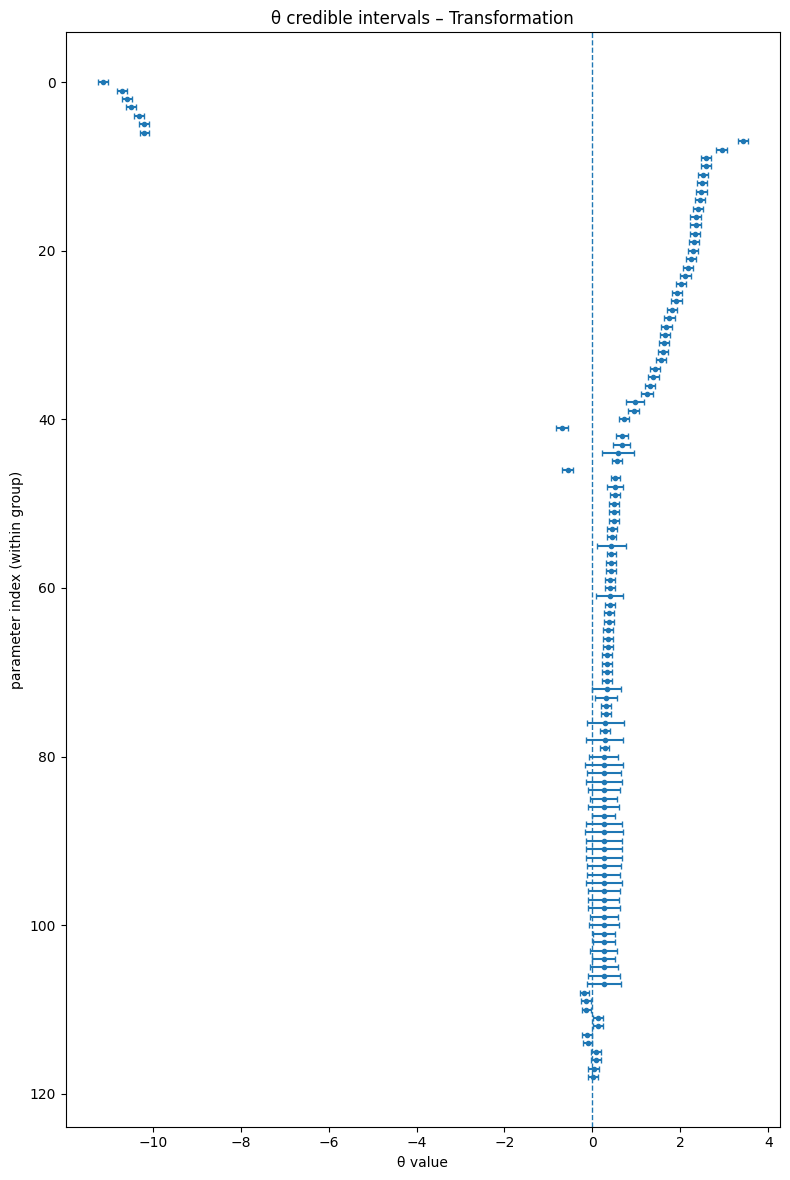

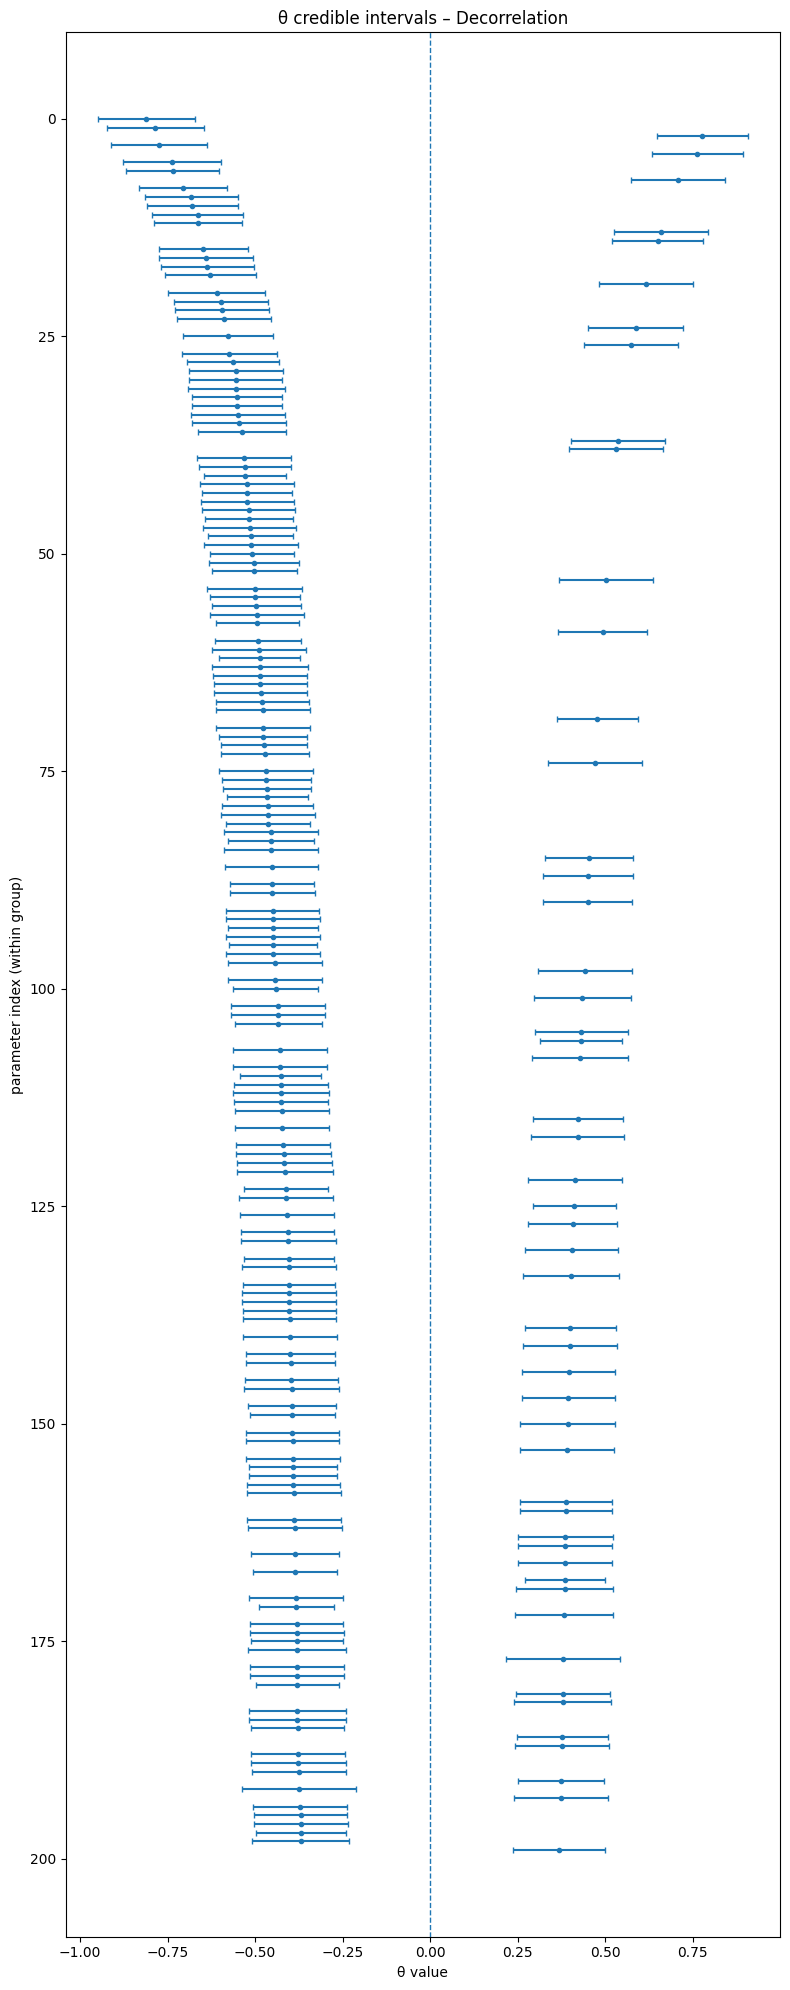

In [49]:
CI_groups = theta_ci_by_group(VI, level=0.95, sort_within_group=True)

if CI_groups["transformation"] is not None:
    plot_theta_ci_group(CI_groups["transformation"], "Transformation", max_params=200)

if CI_groups["decorrelation"] is not None:
    plot_theta_ci_group(CI_groups["decorrelation"], "Decorrelation", max_params=200)


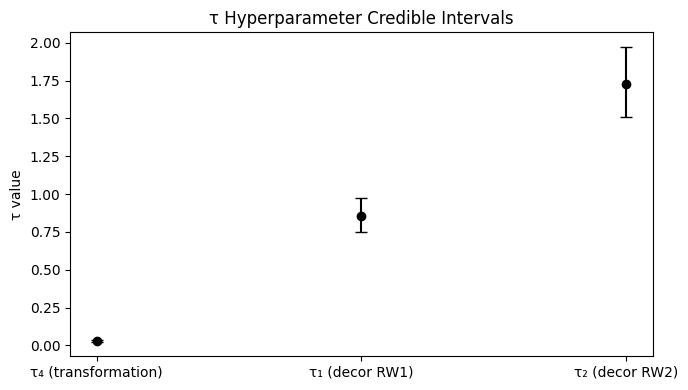

In [38]:
ci_4 = tau_ci_from_node(tau_nodes.node4)
ci_2 = tau_ci_from_node(tau_nodes.node2)
ci_1 = tau_ci_from_node(tau_nodes.node1)

tau_info = [
    ("τ₄ (transformation)", ci_4["mean"], ci_4["lower"], ci_4["upper"]),
]
if True: ### decor_present output from train method
    tau_info += [
        ("τ₁ (decor RW1)", ci_1["mean"], ci_1["lower"], ci_1["upper"]),
        ("τ₂ (decor RW2)", ci_2["mean"], ci_2["lower"], ci_2["upper"]),
    ]
plot_tau_nodes(tau_info)

we plot synthetic samples and overlay the conditional dependence structure for all pairs with strong conditional dependence according to there IAE metric.

In [26]:
synthetic_samples = model.sample(2000)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_model/gtm.py:1299: UserWarning: Transformation layer does not have an inverse. Inverse is approximated
  warnings.warn(


[FIX] var 0: valid interval = [-9.999999, 9.999999]
[FIX] var 1: valid interval = [-9.999999, 9.999999]
[FIX] var 2: valid interval = [-9.999999, 9.999999]
[FIX] var 3: valid interval = [-9.999999, 9.999999]
[FIX] var 4: valid interval = [-9.999999, 9.999999]
[FIX] var 5: valid interval = [-9.999999, 9.999999]
[FIX] var 6: valid interval = [-9.999999, 9.999999]


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm_env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


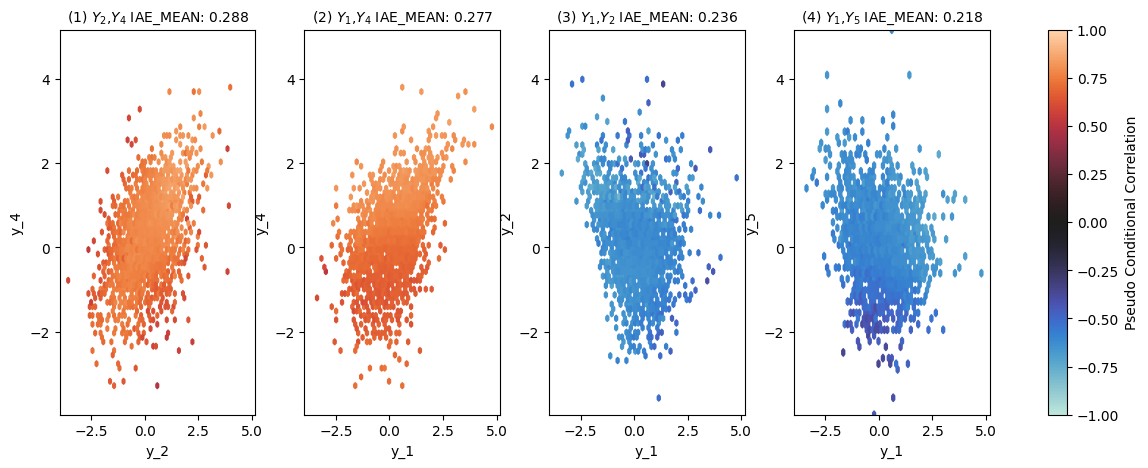

In [27]:
model.plot_conditional_dependence_structure(data=synthetic_samples,
                          dependence_metric_threshholding="iae_mean",
                          minimum_dependence_threshold=0.2, 
                          )

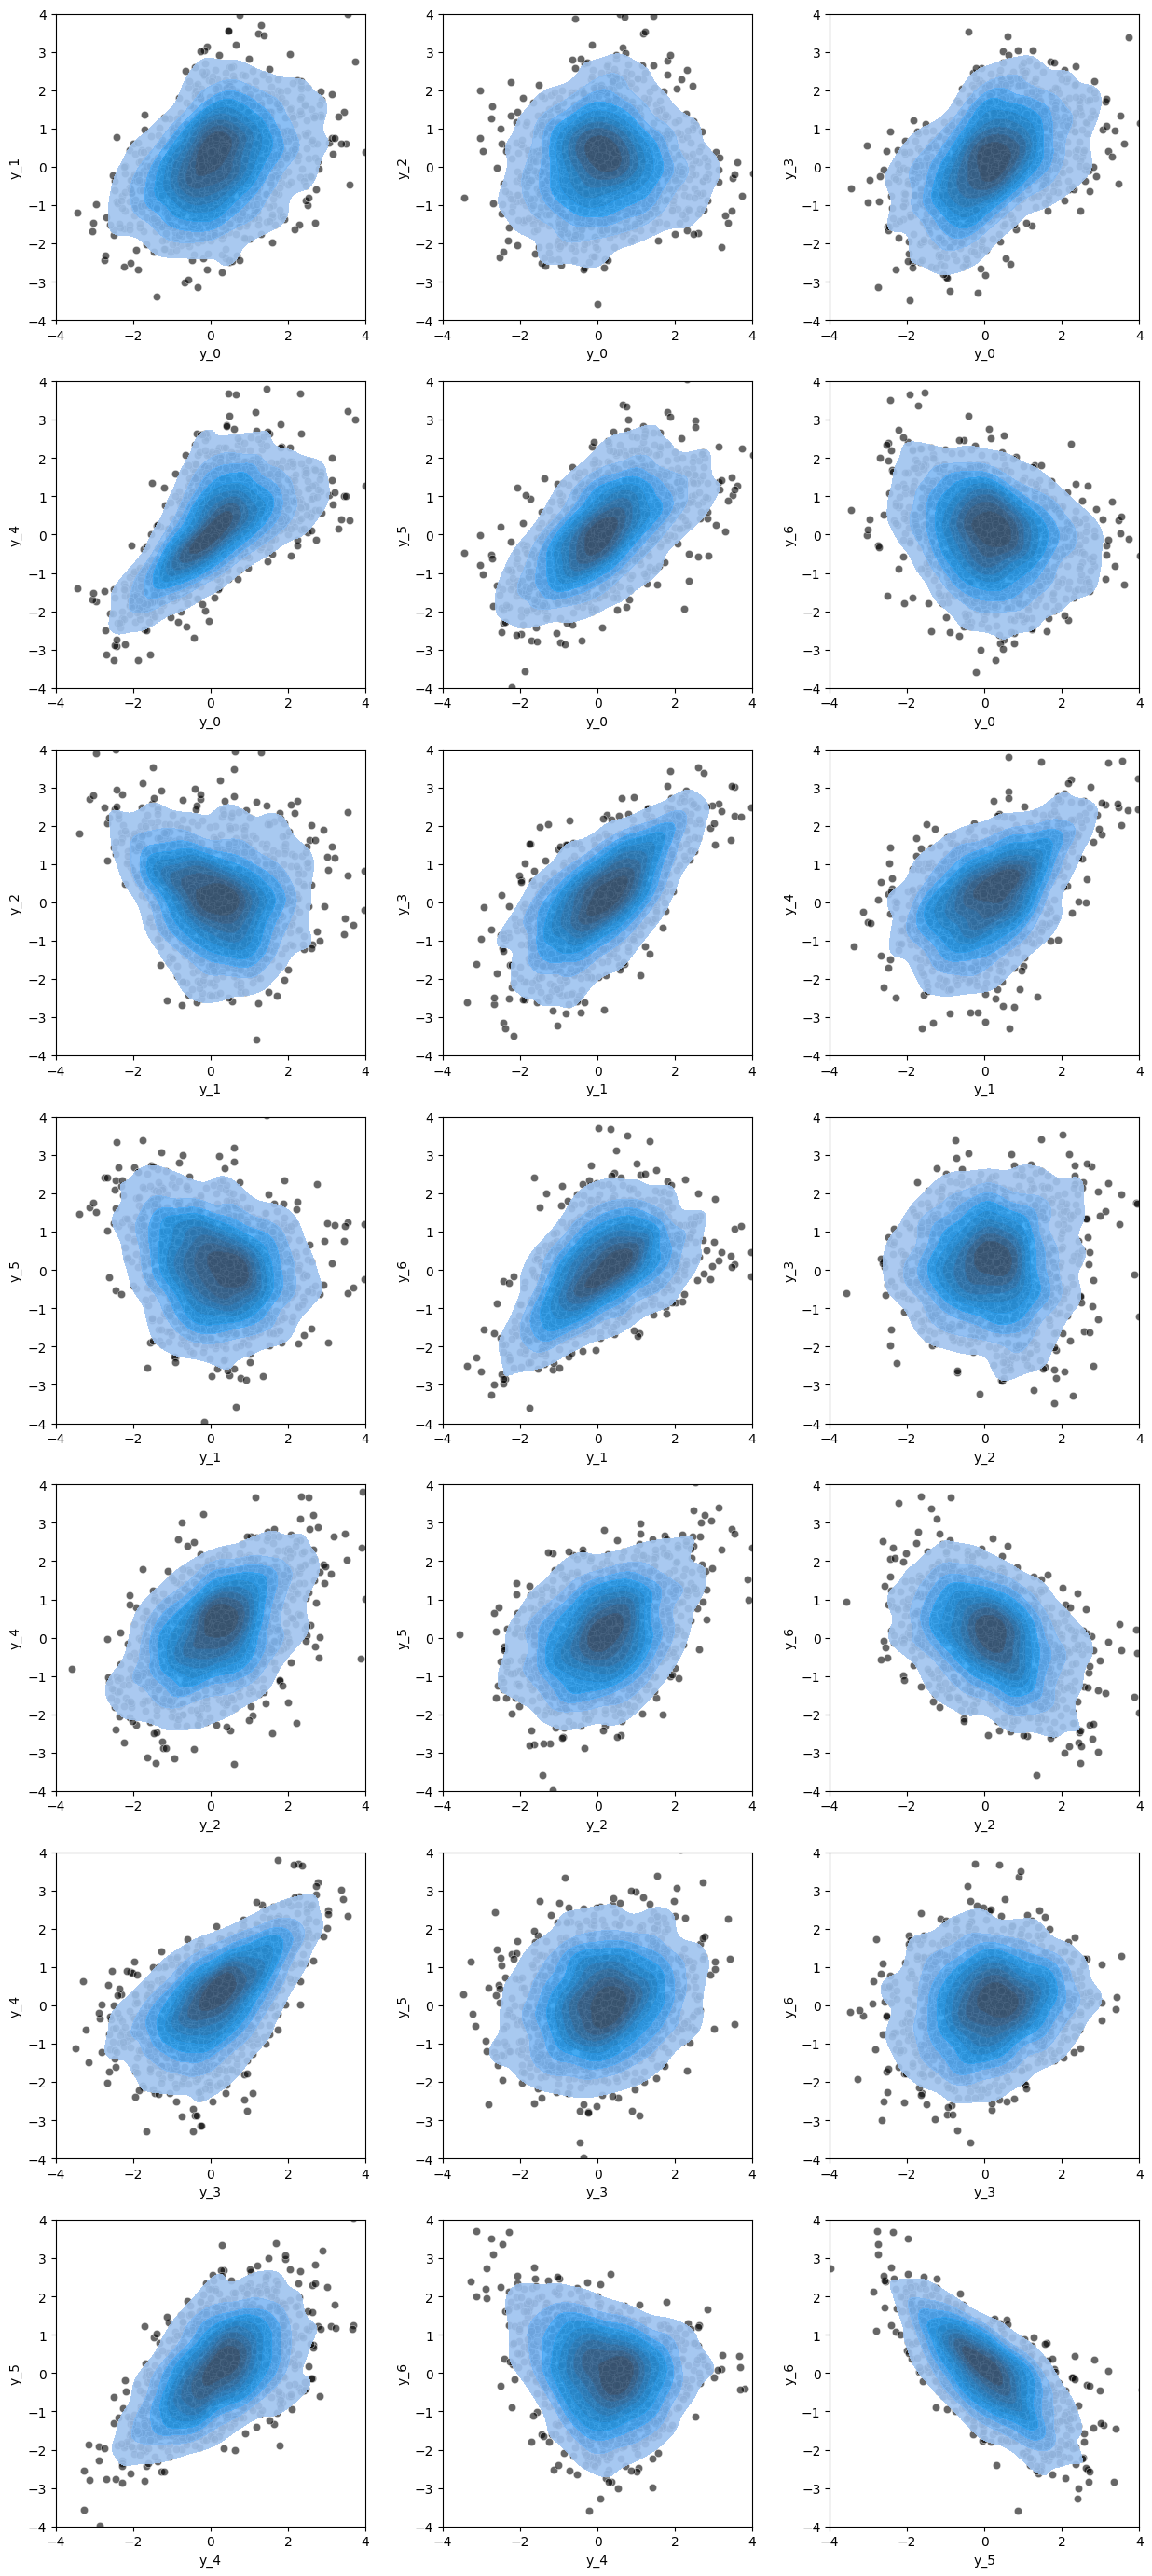

In [28]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The splines of the model, 10 transformation layer splines and 3 x 45 decorrelation layer splines can also be plotted.

In [27]:
#model.plot_splines(layer_type="transformation")

In [28]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

In [29]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

In [30]:
#model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)

### 6. Identifying the Conditional Independence Graph

We compare the true known conditional independence Graph to the one learned by the GTM. To do so we first merge the true structure table with our learned one.

In [29]:
merged_ci_tables = pd.merge(
    conditional_independence_table,
    df_true_structure_sub,
    on=["var_row", "var_col"]
)


take a look at the table and sort by some idicator such as iae.

In [32]:
#merged_ci_tables.sort_values("iae",ascending=False) 

with the spearman and pearson correlations one can see how similar the metrics are and how strongly correlated they are to the dependence.

In [30]:
merged_ci_tables.corr("spearman") #"pearson"

,index,var_row,var_col,abs_mean,mean,std,min,q_1,q_5,q_10,...,cond_correlation_abs_lo,cond_correlation_abs_hi,cond_correlation_square_mean,kld_mean,kld_lo,kld_hi,iae_mean,iae_lo,iae_hi,dependence
index,1.000000,0.977008,0.642034,-0.192208,0.150649,-0.236364,0.262338,0.227273,0.201299,0.184416,...,-0.228571,-0.135065,-0.157143,-0.224675,-0.224675,-0.224675,-0.211688,-0.211688,-0.211688,-0.062984
var_row,0.977008,1.000000,0.471429,-0.209359,0.120963,-0.208030,0.254554,0.212682,0.180780,0.152865,...,-0.246578,-0.166158,-0.181444,-0.243920,-0.243920,-0.243920,-0.233950,-0.233950,-0.233950,-0.056408
var_col,0.642034,0.471429,1.000000,-0.011299,0.156853,-0.210688,0.130932,0.148213,0.150207,0.186097,...,-0.021933,0.088396,0.052506,-0.012628,-0.012628,-0.012628,0.007976,0.007976,0.007976,0.008058
abs_mean,-0.192208,-0.209359,-0.011299,1.000000,-0.292208,0.809091,-0.335065,-0.333766,-0.328571,-0.311688,...,0.974026,0.971429,0.977922,0.963636,0.963636,0.963636,0.977922,0.977922,0.977922,0.645583
mean,0.150649,0.120963,0.156853,-0.292208,1.000000,-0.348052,0.910390,0.954545,0.970130,0.988312,...,-0.318182,-0.319481,-0.305195,-0.280519,-0.280519,-0.280519,-0.306494,-0.306494,-0.306494,-0.204697
std,-0.236364,-0.208030,-0.210688,0.809091,-0.348052,1.000000,-0.490909,-0.487013,-0.471429,-0.427273,...,0.806494,0.740260,0.777922,0.805195,0.805195,0.805195,0.801299,0.801299,0.801299,0.834534
min,0.262338,0.254554,0.130932,-0.335065,0.910390,-0.490909,1.000000,0.976623,0.964935,0.941558,...,-0.394805,-0.364935,-0.364935,-0.358442,-0.358442,-0.358442,-0.379221,-0.379221,-0.379221,-0.409394
q_1,0.227273,0.212682,0.148213,-0.333766,0.954545,-0.487013,0.976623,1.000000,0.994805,0.976623,...,-0.363636,-0.344156,-0.338961,-0.327273,-0.327273,-0.327273,-0.350649,-0.350649,-0.350649,-0.346410
q_5,0.201299,0.180780,0.150207,-0.328571,0.970130,-0.471429,0.964935,0.994805,1.000000,0.989610,...,-0.357143,-0.340260,-0.337662,-0.319481,-0.319481,-0.319481,-0.346753,-0.346753,-0.346753,-0.330664
q_10,0.184416,0.152865,0.186097,-0.311688,0.988312,-0.427273,0.941558,0.976623,0.989610,1.000000,...,-0.341558,-0.320779,-0.319481,-0.305195,-0.305195,-0.305195,-0.331169,-0.331169,-0.331169,-0.267681


however the proper metric as identifying full conditional independence is a classification task is the AUC (Area under the ROC-Curve).

In [31]:
auc_iae = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
auc_kld = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
auc_corr = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
auc_pmat = roc_auc_score(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
print("AUC IAE                    :",auc_iae)
print("AUC KLD                    :",auc_kld)
print("AUC Conditional Correlation:",auc_corr)
print("AUC Precision Matrix       :",auc_pmat)

AUC IAE                    : 0.8909090909090909
AUC KLD                    : 0.8909090909090909
AUC Conditional Correlation: 0.8909090909090909
AUC Precision Matrix       : 0.8727272727272728


We further print the ROC Curves for different metrics.

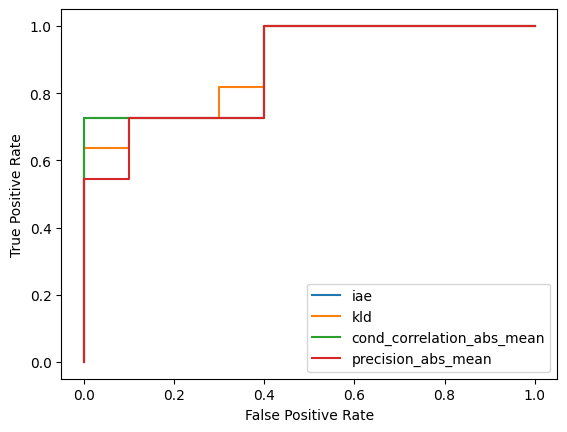

In [32]:
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["iae_mean"])
plt.plot(fpr, tpr, label="iae")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["kld_mean"])
plt.plot(fpr, tpr, label="kld")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["cond_correlation_abs_mean"])
plt.plot(fpr, tpr, label="cond_correlation_abs_mean")
fpr, tpr, thresholds = roc_curve(merged_ci_tables["dependence"], merged_ci_tables["precision_abs_mean"])
plt.plot(fpr, tpr, label="precision_abs_mean")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()